In [1]:
from IPython.display import display, HTML

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [169]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import transformers
import pandas as pd
import numpy as np
from transformers import BertModel, BertTokenizer
from Scripts.utils.bert_utils import load_tokenizer
from nltk.corpus import stopwords 
from Scripts.utils.preprocess_utils import preprocess_texts
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import random
import itertools
from Scripts.utils.bert_embeddings import load_bert_embeddings
from Scripts.utils.clustering_utils import run_clustering, get_cluster_sizes, score_cluster, get_cluster_pairs, get_pairwise_dist, cluster2doc, filter_clusters, get_top_100_clusterpairs
from Scripts.utils.general_utils import timer
import Scripts.utils.config as CONFIG
from attm_utils import load_pickle
from attm_dataloaders import CPDatasetMT, CPDatasetST
from attm_data_utils import get_train_test_ssda
from attm_metrics import calculate_scores, calculate_scores_single, get_accuracy_from_logits,print_res
from attm_model_utils import evaluate_mt, evaluate_st
from attm_single_task import AttentionST
from attm_multi_task import AttentionMT
import  gc
import time
import pickle
import dill

In [160]:
from attm_utils import batch_text_gen, batch_gen_pred, tokenize_4bert_batch

In [6]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['axes.grid'] = True

In [7]:
np.random.seed(CONFIG.RANDOM_SEED)

In [8]:
torch.manual_seed(24)

In [9]:
torch.multiprocessing.set_sharing_strategy('file_system')

In [10]:
# Datagen from clean_df

In [175]:
def run_ssda_cp_mt(df,cp,doc_2_cluster_map,
                   learning_rates=[0.0001,0.001,0.01,0.1],
                   epochs=3,
                   word_pred_loss_weights=[0.3,0.8],
                   batch_size=8,
                   neg_sample_size=3,
                   single_task=False,
                   cuda_device=torch.device('cuda:1')):
    """
    Uses a self supervised domain adaptation setting to train the model
    
    * train = 90% c1 data + 10% c2 data
    * test = 50% c1 data + 50% c2 data
    
    * From cluster 1 choose 70% of the data for train, 30% for test
    * From cluster 2 choose 10% of 70% from c1 for train, 
    
    * Loss check
    * Metrics = F1, recall, precision, accuracy, roc
    """
    train, test,val = get_train_test_ssda(df,cp,doc_2_cluster_map,neg_sample_size=neg_sample_size,single_task=single_task)
    metrics_train = {}
    metrics_test = {}
    losses_train = {}
    model_dict = {}
    # train ssda func
    for lr in learning_rates:
        for word_loss_w in word_pred_loss_weights:
            
            # FREE MEMORY
            model = None
            gc.collect()
            torch.cuda.empty_cache()

            model, epoch_losses, scores_train, scores_test = run_ssda_MT(train,test,val,lr,word_loss_w,epochs=epochs,batch_size=batch_size,cuda_device=cuda_device,num_workers=4)
            metrics_train[(lr,word_loss_w)] = scores_train
            metrics_test[(lr,word_loss_w)] = scores_test
            losses_train[(lr,word_loss_w)] = epoch_losses
            model_dict[(lr,word_loss_w)] = model
            
    return metrics_train,metrics_test, losses_train, model_dict

def run_ssda_cp_st(df,cp,doc_2_cluster_map,
                   learning_rates=[0.0001,0.001,0.01,0.1],
                   epochs=3,
                   word_pred_loss_weights=[0.3,0.8],
                   batch_size=8,
                   neg_sample_size=3,
                   single_task=True,
                   with_attention=True,
                   cuda_device=torch.device('cuda:1')):
    """
    Uses a self supervised domain adaptation setting to train the model
    
    * train = 90% c1 data + 10% c2 data
    * test = 50% c1 data + 50% c2 data
    
    * From cluster 1 choose 70% of the data for train, 30% for test
    * From cluster 2 choose 10% of 70% from c1 for train, 
    
    * Loss check
    * Metrics = F1, recall, precision, accuracy, roc
    """
    train, test, val = get_train_test_ssda(df,cp,doc_2_cluster_map,neg_sample_size=neg_sample_size,single_task=single_task)
    metrics_train = {}
    metrics_test = {}
    losses_train = {}
    model_dict = {}
    # train ssda func
    for lr in learning_rates:
            
        # FREE MEMORY
        model = None
        gc.collect()
        torch.cuda.empty_cache()

        model, epoch_losses, scores_train, scores_test = run_ssda_ST(train,test,val,lr,epochs=epochs,batch_size=batch_size,cuda_device=cuda_device,num_workers=4,with_attention=with_attention)

        metrics_train[(lr)] = scores_train
        metrics_test[(lr)] = scores_test
        losses_train[(lr)] = epoch_losses
        model_dict[(lr)] = model
        
    return metrics_train,metrics_test, losses_train, model_dict

In [143]:
@timer
def run_ssda_MT(train,test,val,lr,word_loss_w,epochs=2,batch_size=8,cuda_device=torch.device('cuda:1'),num_workers=1):
    """
    """
    model = AttentionMT(embedding_size=768,verbose=False,which_forward=2)
    model.to(cuda_device)
    loss_func = nn.BCELoss()
    opt = torch.optim.Adam(model.parameters(),lr=lr)
    
    epoch_losses = {}
    total_losses = []
    word_losses = []
    rs_losses = []
    total_losses_val = []
    word_losses_val = []
    rs_losses_val = []
    
    train_dataset = CPDatasetMT(train)
    test_dataset = CPDatasetMT(test)
    val_dataset = CPDatasetMT(val)
    train_dataloader = DataLoader(train_dataset,batch_size=batch_size,num_workers=num_workers, shuffle=True)
    test_dataloader = DataLoader(test_dataset,batch_size=batch_size,num_workers=num_workers,shuffle=True)
    val_dataloader = DataLoader(val_dataset,batch_size=batch_size,num_workers=num_workers,shuffle=True)
    
    for epoch in range(epochs):
        
        batch_losses_total = []
        batch_losses_rec = []
        batch_losses_word = []
        
        for batch_num, (x1,x2,y1,y2,wc) in enumerate(train_dataloader):
            
            model.train()

            x1,x2,y1,y2 = x1.to(cuda_device),x2.to(cuda_device),y1.to(cuda_device),y2.to(cuda_device)
            
            opt.zero_grad() # reset all the gradient information
    
            y_pred, context_pred, attention_vector = model(x1, x2)
        
            if batch_size == 1:
                y_pred = y_pred.view(1,1)
                context_pred = context_pred.view(1,1)
            
            rec_loss = loss_func(y_pred,y1)
            word_loss = loss_func(context_pred,y2)
            
            total_loss = rec_loss + (word_loss_w * word_loss)
            
            total_loss.backward()
            
            opt.step()
            
            batch_losses_rec.append(rec_loss.item())
            batch_losses_word.append(word_loss.item())
            batch_losses_total.append(total_loss.item())
            
            if batch_num % 100 == 0 and batch_num >=100:
                print("Epoch : %s | Batch : %s | Total Loss : %s | Rec Loss : %s | Word Loss : %s" % (str(epoch),str(batch_num),str(total_loss.item()),str(rec_loss.item()),str(word_loss.item())))
                print("True Rec Labels : %s" %str(y1))
                print("True Word Labels : %s" %str(y2))
                print("Batch Class Predictions : %s"%str(y_pred))
                print("Batch Word Label Predictions : %s"%str(context_pred))
                print("Batch Accuracy class : %s"%str(get_accuracy_from_logits(y_pred,y1)))
                print("Batch Accuracy word : %s"%str(get_accuracy_from_logits(context_pred,y2)))
            
        batch_losses_total_val = []
        batch_losses_rec_val = []
        batch_losses_word_val = []
        
        for bn_v, (xv1,xv2,yv1,yv2,wcv) in enumerate(val_dataloader):
            
            model.eval()
            with torch.no_grad():
                xv1,xv2,yv1,yv2 = xv1.to(cuda_device),xv2.to(cuda_device),yv1.to(cuda_device),yv2.to(cuda_device)

                y_pred, context_pred, attention_vector, attention_comb_weights = model(xv1, xv2)
                
                if batch_size == 1:
                    y_pred = y_pred.view(1,1)
                    context_pred = context_pred.view(1,1)
            
                rec_loss = loss_func(y_pred,yv1)
                word_loss = loss_func(context_pred,yv2)
            
                total_loss = rec_loss + (word_loss_w * word_loss)
                
                batch_losses_rec_val.append(rec_loss.item())
                batch_losses_word_val.append(word_loss.item())
                batch_losses_total_val.append(total_loss.item())
        
        avg_batch_losses_total = np.mean(batch_losses_total)
        avg_batch_losses_rec = np.mean(batch_losses_rec)
        avg_batch_losses_word = np.mean(batch_losses_word)
        
        avg_batch_losses_total_val =np.mean(batch_losses_total)
        avg_batch_losses_rec_val = np.mean(batch_losses_total_val)
        avg_batch_losses_word_val =np.mean(batch_losses_word_val)
        
        print("Avg Batch Total Loss Train : %s" %str(avg_batch_losses_total))
        print("Avg Batch Toal Loss Val : %s" %str(avg_batch_losses_total_val))
        
        total_losses.append(avg_batch_losses_total)
        word_losses.append(avg_batch_losses_word)
        rs_losses.append(avg_batch_losses_rec)
        total_losses_val.append(avg_batch_losses_total_val)
        word_losses_val.append(avg_batch_losses_word_val)
        rs_losses_val.append(avg_batch_losses_rec_val)
        
        
            
    epoch_losses["rs_loss"] = rs_losses
    epoch_losses["word_loss"] = word_losses
    epoch_losses["total_loss"] = total_losses
    epoch_losses["rs_loss_val"] = rs_losses_val
    epoch_losses["word_loss_val"] = word_losses_val
    epoch_losses["total_loss_val"] = total_losses_val

    scores_train = evaluate_mt(model,train_dataloader)
    scores_test = evaluate_mt(model,test_dataloader)
    
    x1 = None
    x2 = None
    y1 = None
    y2 = None
    rec_loss = None
    total_loss = None
    word_loss = None
    opt = None
    

    del x1
    del x2
    del y1
    del y2

    gc.collect()
    torch.cuda.empty_cache()
    
    return model, epoch_losses, scores_train, scores_test

@timer
def run_ssda_ST(train,test,val,lr,epochs=2,batch_size=8,cuda_device=torch.device('cuda:1'),num_workers=1,with_attention=True):
    """
    """
    model = AttentionST(embedding_size=768,verbose=False,which_forward=2,with_attention=with_attention)
    model.to(cuda_device)
    loss_func = nn.BCELoss()
    opt = torch.optim.Adam(model.parameters(),lr=lr)
    
    epoch_losses = {}
    total_losses = []
    total_losses_val = []
    word_losses = []
    rs_losses = []
    
    train_dataset = CPDatasetST(train)
    test_dataset = CPDatasetST(test)
    val_dataset = CPDatasetST(val)
    train_dataloader = DataLoader(train_dataset,batch_size=batch_size,num_workers=num_workers,shuffle=True)
    test_dataloader = DataLoader(test_dataset,batch_size=batch_size,num_workers=num_workers,shuffle=True)
    val_dataloader = DataLoader(val_dataset,batch_size=batch_size,num_workers=num_workers,shuffle=True)
    for epoch in range(epochs):
        batch_losses =  []
        # Training
        for batch_num, (x1,y1,wc) in enumerate(train_dataloader):
            
            model.train()

            x1,y1 = x1.to(cuda_device),y1.to(cuda_device)
            
            opt.zero_grad() # reset all the gradient information
    
            y_pred, attention_vector = model(x1)
            
            if batch_size == 1:
                y1 = y1.view(1)
            
            if batch_size > 1:
                y1 = y1.squeeze()
            
            
            total_loss = loss_func(y_pred,y1) 
            
            total_loss.backward()
            
            opt.step()
            
            batch_losses.append(total_loss.item())
            
            if batch_num % 100 == 0 and batch_num >=100:
                print("Epoch : %s | Batch : %s | Total Loss : %s " % (str(epoch),str(batch_num),str(total_loss.item())))
                print("True Rec Labels : %s" %str(y1))
                print("Batch Class Predictions : %s"%str(y_pred))
                print("Batch Accuracy class : %s"%str(get_accuracy_from_logits(y_pred,y1)))
        
        # Validation
        batch_losses_val =  []
        for bn_v, (xv1,yv1,wcv) in enumerate(val_dataloader):
            
            model.eval()
            with torch.no_grad():
                xv1,yv1 = xv1.to(cuda_device),yv1.to(cuda_device)

                y_pred, attention_vector = model(xv1)
                
                if batch_size == 1:
                    yv1 = yv1.view(1)
            
                if batch_size > 1:
                    yv1 = yv1.squeeze()

                total_loss_val = loss_func(y_pred,yv1) 
                batch_losses_val.append(total_loss_val.item())
        
        avg_batch_loss = np.mean(batch_losses)
        avg_batch_loss_val = np.mean(batch_losses_val)
        print("Avg Batch Loss Train : %s" %str(avg_batch_loss))
        total_losses.append(avg_batch_loss)
        print("Avg Batch Loss Val : %s" %str(avg_batch_loss_val))
        total_losses_val.append(avg_batch_loss_val)
        
        
    epoch_losses["total_loss"] = total_losses
    epoch_losses["total_loss_val"] = total_losses_val
        
    scores_train = evaluate_st(model,train_dataloader)
    scores_test = evaluate_st(model,test_dataloader)
    
    x1 = None
    y1 = None
    total_loss = None
    opt = None
    

    del x1
    del y1

    gc.collect()
    torch.cuda.empty_cache()
    
    return model, epoch_losses, scores_train, scores_test
    

In [13]:
@timer
def select_cps(cps,cluster_2_doc_map,df,keywords=["democrats", "media","socialist","donald", "republicans", "progressive"]):
    """
    calculate normalized dfs for each cluster pair keywords (sum them for indiv clusters) then rank and then find avg rank
    
    cluster, keyword = doc_freq
    """
    # Get Document frequency for keywords
    clusters = list(set(np.array([[cp[0],cp[1]] for cp in cps]).flatten().tolist()))
    df["processed_all"] = df["processed_title"] + " "+ df['processed_text']
    print("Num clusters : %s" %str(len(clusters)))
    print(clusters)
    keyword_clus_doc_freq = defaultdict(lambda :defaultdict(int))
    for cluster in clusters:
        c_docs = cluster_2_doc_map[cluster]
        for c_doc in c_docs:
            for keyword in keywords:
                if keyword in df["processed_all"].iloc[c_doc]:
                    keyword_clus_doc_freq[cluster][keyword]+=1
        
    # Now lets normalize the scores
    for cluster in clusters:
        for keyword in keywords:
            c_docs = cluster_2_doc_map[cluster]
            if keyword_clus_doc_freq[cluster][keyword] > 0:
                keyword_clus_doc_freq[cluster][keyword] /= len(c_docs)
    
    print(keyword_clus_doc_freq)
    
    # Now lets rank cps
    keyword_clusp_ranks = []
    for cp in cps:
        c1_normdf_total = 0
        c2_normdf_total = 0
        for keyword in keywords:
            c1_normdf_total += keyword_clus_doc_freq[cp[0]][keyword]
            c2_normdf_total += keyword_clus_doc_freq[cp[1]][keyword]
        
        total_cp_norm_df = c1_normdf_total + c2_normdf_total
        keyword_clusp_ranks.append((cp,total_cp_norm_df))
    
    return sorted(keyword_clusp_ranks,key=lambda x: x[1],reverse=True)
        
            

In [14]:
# cps = load_pickle('top100.pickle')

In [15]:
data = load_pickle("att_pickle_objs_input/clean_df.pickle")

In [16]:
data.shape

(95120, 9)

In [17]:
data.columns

Index(['title', 'text', 'source_partisan_score', 'binary_ps', 'processed_text',
       'processed_title', 'context_word_pos', 'context_word_neg', 'drop_'],
      dtype='object')

In [18]:
doc_2_cluster_map = load_pickle('att_pickle_objs_input/d2c_map.pickle')

In [19]:
# type(cps[0][0])

In [41]:
sorted_cps = select_cps(cps,doc_2_cluster_map,data,keywords=["democrats", "media","socialist","donald", "republicans", "progressive"])

Num clusters : 40
[0, 1, 4, 7, 9, 14, 15, 16, 20, 22, 26, 28, 30, 35, 36, 38, 39, 43, 44, 46, 52, 56, 57, 58, 59, 60, 61, 62, 63, 71, 74, 82, 85, 86, 89, 91, 93, 97, 98, 99]
defaultdict(<function select_cps.<locals>.<lambda> at 0x7f223e579ca0>, {0: defaultdict(<class 'int'>, {'democrats': 0.5737142857142857, 'republicans': 0.3417142857142857, 'media': 0.23314285714285715, 'socialist': 0.029714285714285714, 'donald': 0.312, 'progressive': 0.048}), 1: defaultdict(<class 'int'>, {'democrats': 0.26877761413843887, 'media': 0.36818851251840945, 'donald': 0.31516936671575846, 'republicans': 0.13843888070692195, 'progressive': 0.061855670103092786, 'socialist': 0.029455081001472753}), 4: defaultdict(<class 'int'>, {'donald': 0.25183823529411764, 'republicans': 0.09099264705882353, 'democrats': 0.17738970588235295, 'media': 0.32536764705882354, 'socialist': 0.012867647058823529, 'progressive': 0.03768382352941176}), 7: defaultdict(<class 'int'>, {'democrats': 0.44642857142857145, 'media': 0.24

In [42]:
data.columns

Index(['title', 'text', 'source_partisan_score', 'binary_ps', 'processed_text',
       'processed_title', 'context_word_pos', 'context_word_neg', 'drop_',
       'processed_all'],
      dtype='object')

In [1]:
# sorted_cps

In [73]:
metrics_train,metrics_test, losses_train =  run_ssda_cp_st(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.0001,0.001,0.01],
                                                            epochs=5,
                                                            batch_size=4,
                                                            single_task=True,
                                                            with_attention=True)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)

Sample size from C1 in Train : (975, 10)
1 : 423
0 : 552

Sample size from C2 in Train : (97, 10)
1 : 50
0 : 47

Train Size : (1072, 10)
1 : 473
0 : 599

Sample Size from C1 in Test : (419, 10)
1 : 174
0 : 245

Sample Size from C2 in Test : (419, 10)
1 : 215
0 : 204

Test Size : (838, 10)
1 : 389
0 : 449


KeyboardInterrupt: 

In [48]:
metrics_train.keys()

dict_keys([0.01, 0.1])

In [49]:
losses_train.keys()

dict_keys([0.01, 0.1])

In [74]:
metrics_train,metrics_test, losses_train =  run_ssda_cp_mt(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.0001,0.001,0.01],
                                                            word_pred_loss_weights=[0.1,0.3,0.8,1.0],
                                                            epochs=5,
                                                            batch_size=4,
                                                            single_task=False)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)
Exploded Train Shape : (7666, 4)
Exploded Test Shape : (6617, 4)

Sample size from C1 in Train : (5366, 5)
1 : 2354
0 : 3012

Sample size from C2 in Train : (536, 5)
1 : 264
0 : 272

Train Size : (5902, 5)
1 : 2618
0 : 3284

Sample Size from C1 in Test : (2300, 5)
1 : 983
0 : 1317

Sample Size from C2 in Test : (2300, 5)
1 : 1071
0 : 1229

Test Size : (4600, 5)
1 : 2054
0 : 2546
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


KeyboardInterrupt: 

In [44]:
train_scores = None
with open("att_pickle_objs_results/(0, 30)_metrics_train_single.pickle","rb") as handle:
    train_scores = dill.load(handle)

In [45]:
train_scores.keys()

dict_keys([1e-05, 0.0001, 0.001, 0.01])

In [46]:
train_scores[0.01].keys()

dict_keys(['overall', 'cluster1', 'cluster2'])

In [47]:
train_scores[0.01]["overall"]

defaultdict(<function attm_metrics.<lambda>()>,
            {'class_scores': defaultdict(float,
                         {'f1': 0.7741935483870968,
                          'precision': 0.6540284360189573,
                          'recall': 0.9484536082474226,
                          'accuracy': 0.7831273276839208,
                          'roc_auc': 0.7607726597325408})})

In [48]:
train_loss = None
with open("att_pickle_objs_results/(0, 30)_loss_single.pickle","rb") as handle:
    train_loss = dill.load(handle)

In [49]:
train_loss.keys()

dict_keys([1e-05, 0.0001, 0.001, 0.01])

422.5

In [56]:


N = 5
max_val, min_val = 0.01, 0.00000001
range_size = (max_val - min_val)  # 2
np.random.rand(N) * range_size + min_val

array([3.41245396e-03, 8.08114567e-03, 3.30546702e-03, 8.55788631e-03,
       8.65761124e-05])

In [60]:
def random_search_lr(n,max_lr=0.001,min_lr=0.0000001):
    """
    """
    range_size = (max_lr - min_lr)  # 2
    lrs = (np.random.rand(n) * range_size + min_lr).tolist()
    return lrs

In [61]:
lr = random_search_lr(10)

In [62]:
lr

[0.0007231048406679875,
 0.00039861319973326647,
 0.00015914792150126708,
 0.0006502884253383948,
 0.0006411521123407676,
 0.00023396399376241435,
 0.00012714200346605468,
 0.0003312195494200387,
 0.00031714525589067124,
 0.000781623522986814]

In [116]:
def plot_epoch_loss_multi(epoch_losses):
    """
    """
    fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(25,10))
    
    axes = ax.ravel()
    
    ax[0].plot(range(len(epoch_losses["total_loss"])),epoch_losses["total_loss"],c="green",alpha=0.4,label="Total Loss")
    ax[0].plot(range(len(epoch_losses["word_loss"])),epoch_losses["word_loss"],c="blue",alpha=0.3,label="Word Loss")
    ax[0].plot(range(len(epoch_losses["rs_loss"])),epoch_losses["rs_loss"],c="red",label="RS Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Training Loss")
    ax[0].set_title("Training Loss for ATMT")
    
    ax[1].plot(range(len(epoch_losses["total_loss_val"])),epoch_losses["total_loss_val"],c="green",alpha=0.4,label="Total Loss")
    ax[1].plot(range(len(epoch_losses["word_loss_val"])),epoch_losses["word_loss_val"],c="blue",alpha=0.3,label="Word Loss")
    ax[1].plot(range(len(epoch_losses["rs_loss_val"])),epoch_losses["rs_loss_val"],c="red",label="RS Loss")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Validation Loss")
    ax[1].set_title("Validation Loss for ATMT")
    plt.legend()
    plt.show()

In [52]:
def plot_epoch_loss(epoch_losses):
    """
    """
    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(25,10))
    ax.plot(range(len(epoch_losses["total_loss"])),epoch_losses["total_loss"],c="green",label="Training Loss")
    ax.plot(range(len(epoch_losses["total_loss_val"])),epoch_losses["total_loss_val"],c="red",label="Validation Loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Training Loss")
    plt.legend()
    plt.show()

In [65]:
scores_test =  None
losses_train = None
with open("att_pickle_objs_results/(14, 44)_metrics_test_single.pickle","rb") as mt:
    scores_test = dill.load(mt)
with open("att_pickle_objs_results/(14, 44)_loss_single.pickle","rb") as mt:
    losses_train = dill.load(mt)

In [66]:
print_res(scores_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,0.00100,overall,class_scores,0.449468,0.465565,0.434447,0.505967,0.501188
1,0.00100,cluster1,class_scores,0.558282,0.598684,0.522989,0.656325,0.637004
2,0.00100,cluster2,class_scores,0.366197,0.369668,0.362791,0.355609,0.355415
3,0.00010,overall,class_scores,0.200758,0.381295,0.136247,0.496420,0.472355
4,0.00010,cluster1,class_scores,0.236842,0.500000,0.155172,0.584726,0.522484
5,0.00010,cluster2,class_scores,0.173333,0.305882,0.120930,0.408115,0.415857
6,0.00001,overall,class_scores,0.043373,0.346154,0.023136,0.526253,0.492637
7,0.00001,cluster1,class_scores,0.052910,0.333333,0.028736,0.572792,0.493960
8,0.00001,cluster2,class_scores,0.035398,0.363636,0.018605,0.479714,0.492145


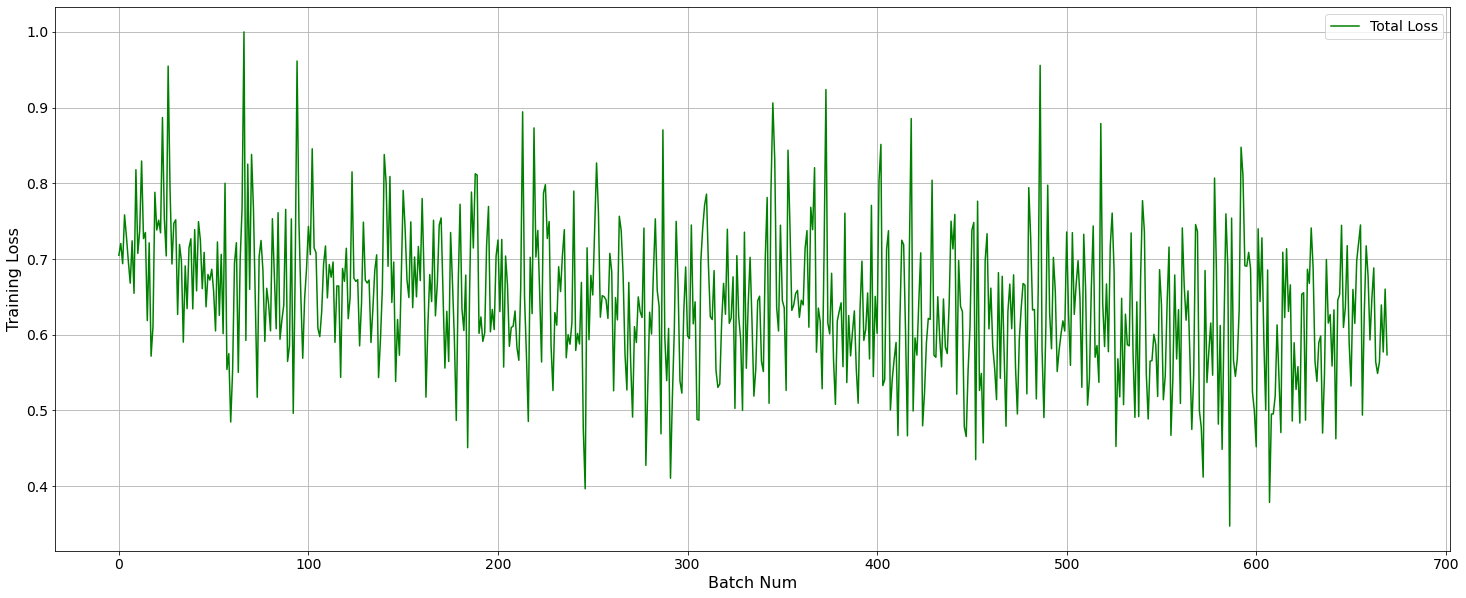

In [75]:
plot_epoch_loss(losses_train[0.001])

In [68]:
scores_test_w_att =  None
losses_train_w_att = None
with open("att_pickle_objs_results/(14, 44)_metrics_test_single_att.pickle","rb") as mt:
    scores_test_w_att = dill.load(mt)
with open("att_pickle_objs_results/(14, 44)_loss_single_att.pickle","rb") as mt:
    losses_train_w_att = dill.load(mt)

In [69]:
print_res(scores_test_w_att)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,0.00100,overall,class_scores,0.380518,0.466418,0.321337,0.514320,0.501426
1,0.00100,cluster1,class_scores,0.594406,0.758929,0.488506,0.723150,0.689151
2,0.00100,cluster2,class_scores,0.215633,0.256410,0.186047,0.305489,0.308710
3,0.00010,overall,class_scores,0.188235,0.396694,0.123393,0.505967,0.480405
4,0.00010,cluster1,class_scores,0.207207,0.479167,0.132184,0.579952,0.515072
5,0.00010,cluster2,class_scores,0.173611,0.342466,0.116279,0.431981,0.440492
6,0.00001,overall,class_scores,0.000000,0.000000,0.000000,0.535800,0.500000
7,0.00001,cluster1,class_scores,0.000000,0.000000,0.000000,0.584726,0.500000
8,0.00001,cluster2,class_scores,0.000000,0.000000,0.000000,0.486874,0.500000


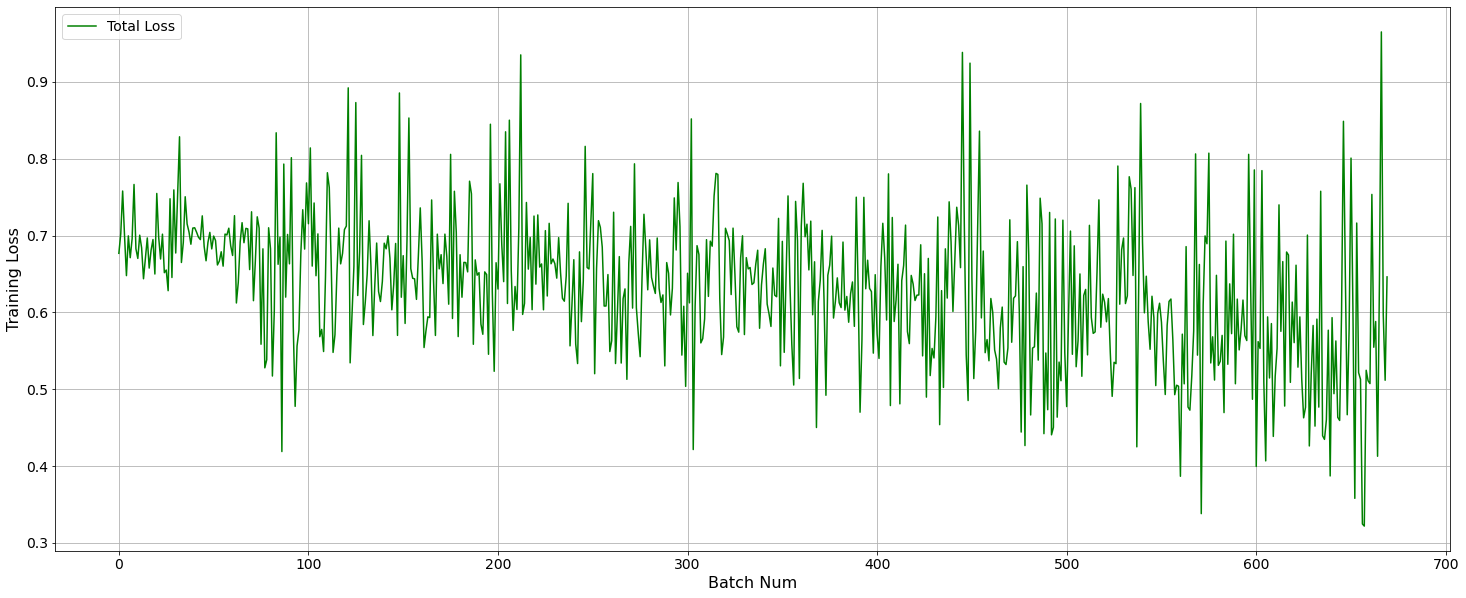

In [70]:
plot_epoch_loss(losses_train_w_att[0.001])

In [71]:
scores_test_multi_att = None
losees_train_multi_att = None
with open("att_pickle_objs_results/(14, 44)_metrics_test_multi_att.pickle","rb") as mt:
    scores_test_multi_att = dill.load(mt)
with open("att_pickle_objs_results/(14, 44)_loss_multi_att.pickle","rb") as mt:
    losees_train_multi_att = dill.load(mt)

In [72]:
print_res(scores_test_multi_att)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 0.1)",overall,class_scores,0.599106,0.453952,0.880721,0.473696,0.513023
1,"(0.001, 0.1)",overall,word_scores,0.559884,0.450832,0.738528,0.471957,0.494065
2,"(0.001, 0.1)",cluster1,class_scores,0.621300,0.466769,0.928789,0.516087,0.568419
3,"(0.001, 0.1)",cluster1,word_scores,0.556126,0.449852,0.728146,0.473913,0.495924
4,"(0.001, 0.1)",cluster2,class_scores,0.578065,0.441597,0.836601,0.431304,0.457357
5,"(0.001, 0.1)",cluster2,word_scores,0.563552,0.451780,0.748811,0.470000,0.492099
6,"(0.001, 0.4)",overall,class_scores,0.322156,0.495951,0.238559,0.551739,0.521479
7,"(0.001, 0.4)",overall,word_scores,0.562995,0.451501,0.747610,0.472174,0.495017
8,"(0.001, 0.4)",cluster1,class_scores,0.448370,0.674847,0.335707,0.646957,0.607489
9,"(0.001, 0.4)",cluster1,word_scores,0.559796,0.450292,0.739673,0.473478,0.496525


In [57]:
losees_train_multi_att.keys()

dict_keys([(0.001, 0.1), (0.001, 0.4), (0.001, 0.8), (0.0001, 0.1), (0.0001, 0.4), (0.0001, 0.8), (1e-05, 0.1), (1e-05, 0.4), (1e-05, 0.8)])

In [58]:
losees_train_multi_att[(0.001, 0.8)].keys()

dict_keys(['rs_loss', 'word_loss', 'total_loss'])

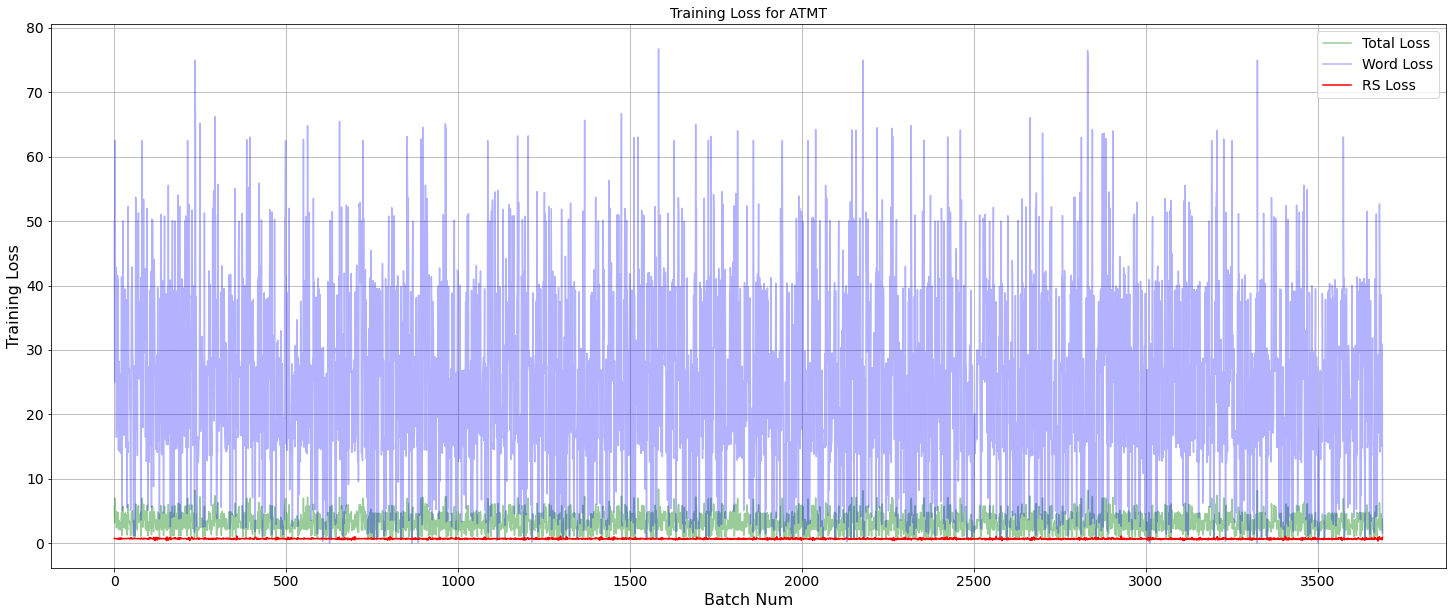

In [76]:
plot_epoch_loss_multi(losees_train_multi_att[(0.001, 0.1)])

# Overfit test

We want to check if the model is overfitting on a small data size to make sure the loss curve can be smooth , if not we need to add more layers as the model is too simple to capture patterns.

### Using Batch Size of 1

In [97]:
metrics_train,metrics_test, losses_train =  run_ssda_cp_st(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.001],
                                                            epochs=10,
                                                            batch_size=1,
                                                            single_task=True,
                                                            with_attention=False)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)

Sample size from C1 in Train : (1003, 10)
1 : 428
0 : 575

Sample size from C2 in Train : (100, 10)
1 : 53
0 : 47

Train Size : (1103, 10)
1 : 481
0 : 622

Sample Size from C1 in Test : (279, 10)
1 : 115
0 : 164

Sample Size from C2 in Test : (279, 10)
1 : 148
0 : 131

Test Size : (558, 10)
1 : 263
0 : 295

Sample size from C1 in Val : (112, 10)
1 : 54
0 : 58

Sample size from C2 in Val : (112, 10)
1 : 44
0 : 68

Val Size : (224, 10)
1 : 98
0 : 126
Epoch : 0 | Batch : 100 | Total Loss : 0.4746896028518677 
True Rec Labels : tensor([1.], device='cuda:1')
Batch Class Predictions : tensor([0.6221], device='cuda:1', grad_fn=<SigmoidBackward>)
[1.]
Batch Accuracy class : 1.0
Epoch : 0 | Batch : 200 | Total Loss : 0.7725903987884521 
True Rec Labels : tensor([1.], device='cuda:1')
Batch Class Predictions : tensor([0.4618], device='cuda:1', grad_fn=<SigmoidBackward>)
[0.]
Batch Accuracy class : 0.0
Epoch : 0 | Batch : 300 | Tot

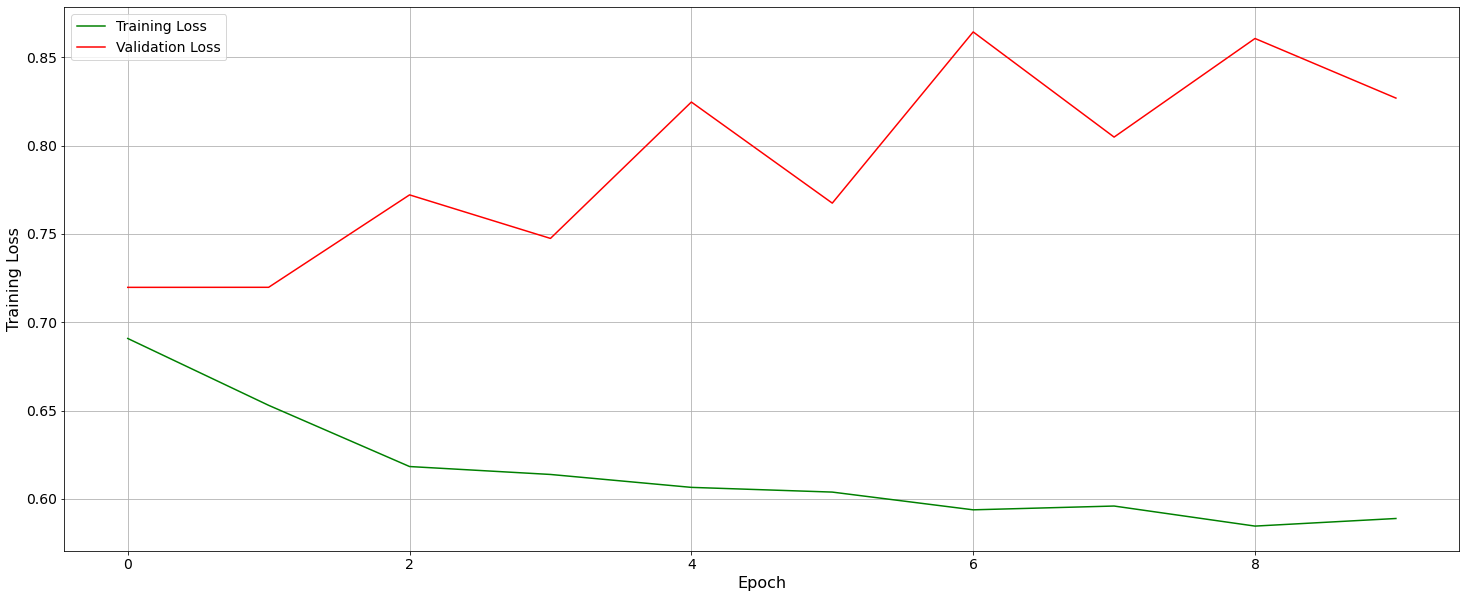

In [98]:
plot_epoch_loss(losses_train[0.001])

In [99]:
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,0.001,overall,class_scores,0.286472,0.473684,0.205323,0.517921,0.500967
1,0.001,cluster1,class_scores,0.405063,0.744186,0.278261,0.663082,0.605594
2,0.001,cluster2,class_scores,0.200913,0.309859,0.148649,0.372760,0.387301


In [100]:
print_res(metrics_train)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,0.001,overall,class_scores,0.485926,0.845361,0.340956,0.685403,0.646362
1,0.001,cluster1,class_scores,0.500835,0.877193,0.350467,0.701894,0.656973
2,0.001,cluster2,class_scores,0.368421,0.608696,0.264151,0.520000,0.536331


In [101]:
metrics_train,metrics_test, losses_train =  run_ssda_cp_st(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.001],
                                                            epochs=10,
                                                            batch_size=1,
                                                            single_task=True,
                                                            with_attention=True)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)

Sample size from C1 in Train : (1003, 10)
1 : 428
0 : 575

Sample size from C2 in Train : (100, 10)
1 : 53
0 : 47

Train Size : (1103, 10)
1 : 481
0 : 622

Sample Size from C1 in Test : (279, 10)
1 : 115
0 : 164

Sample Size from C2 in Test : (279, 10)
1 : 148
0 : 131

Test Size : (558, 10)
1 : 263
0 : 295

Sample size from C1 in Val : (112, 10)
1 : 54
0 : 58

Sample size from C2 in Val : (112, 10)
1 : 44
0 : 68

Val Size : (224, 10)
1 : 98
0 : 126
Epoch : 0 | Batch : 100 | Total Loss : 0.7029039263725281 
True Rec Labels : tensor([1.], device='cuda:1')
Batch Class Predictions : tensor([0.4951], device='cuda:1', grad_fn=<SigmoidBackward>)
[0.]
Batch Accuracy class : 0.0
Epoch : 0 | Batch : 200 | Total Loss : 0.5730432868003845 
True Rec Labels : tensor([0.], device='cuda:1')
Batch Class Predictions : tensor([0.4362], device='cuda:1', grad_fn=<SigmoidBackward>)
[0.]
Batch Accuracy class : 1.0
Epoch : 0 | Batch : 300 | Tot

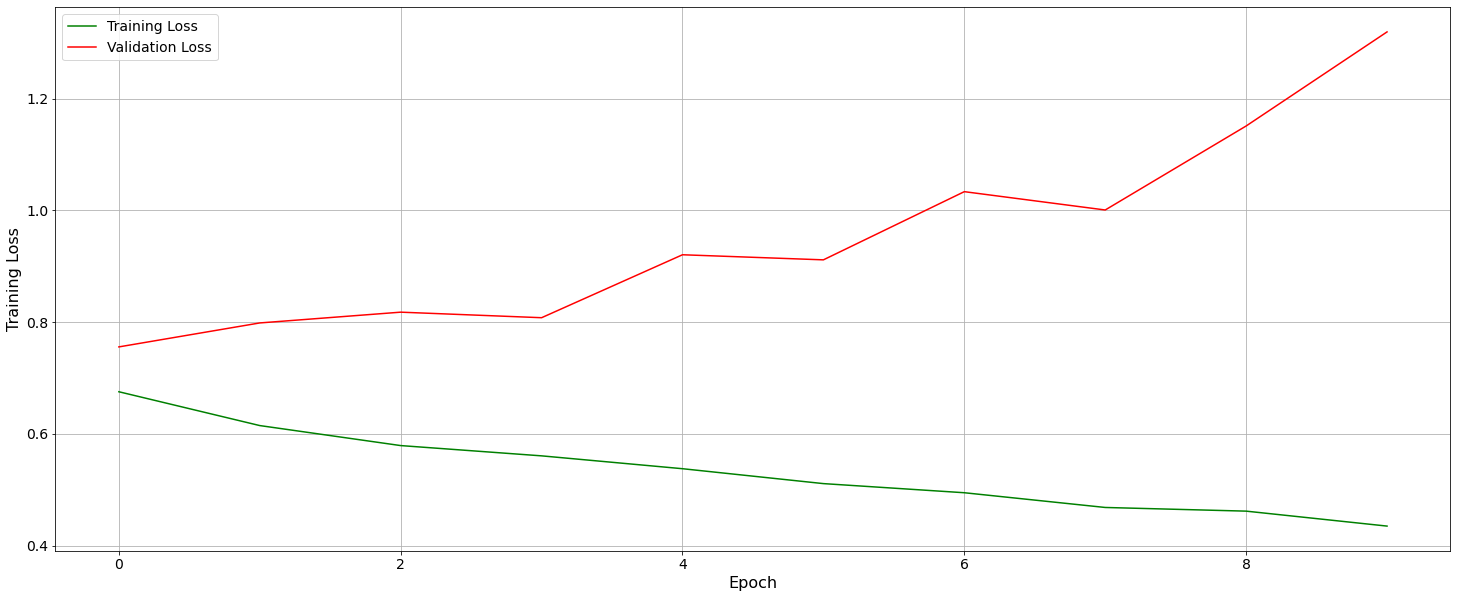

In [102]:
plot_epoch_loss(losses_train[0.001])

In [103]:
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,0.001,overall,class_scores,0.291005,0.478261,0.209125,0.519713,0.502868
1,0.001,cluster1,class_scores,0.432099,0.744681,0.304348,0.670251,0.615589
2,0.001,cluster2,class_scores,0.185185,0.294118,0.135135,0.369176,0.384361


In [104]:
print_res(metrics_train)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,0.001,overall,class_scores,0.572263,0.960784,0.407484,0.734361,0.697311
1,0.001,cluster1,class_scores,0.587276,0.972973,0.420561,0.747757,0.705933
2,0.001,cluster2,class_scores,0.444444,0.842105,0.301887,0.600000,0.619029


### Entire Dataset

#### Without Attention Single Task Network

In [57]:
metrics_train,metrics_test, losses_train =  run_ssda_cp_st(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.0001],
                                                            epochs=20,
                                                            batch_size=16,
                                                            single_task=True,
                                                            with_attention=False)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)

Sample size from C1 in Train : (1003, 10)
1 : 428
0 : 575

Sample size from C2 in Train : (100, 10)
1 : 53
0 : 47

Train Size : (1103, 10)
1 : 481
0 : 622

Sample Size from C1 in Test : (279, 10)
1 : 115
0 : 164

Sample Size from C2 in Test : (279, 10)
1 : 148
0 : 131

Test Size : (558, 10)
1 : 263
0 : 295

Sample size from C1 in Val : (112, 10)
1 : 54
0 : 58

Sample size from C2 in Val : (112, 10)
1 : 44
0 : 68

Val Size : (224, 10)
1 : 98
0 : 126
Avg Batch Loss Train : 0.689199673956719
Avg Batch Loss Val : 0.6821047408240182
Avg Batch Loss Train : 0.6825894782508629
Avg Batch Loss Val : 0.682205502476011
Avg Batch Loss Train : 0.6752168752145076
Avg Batch Loss Val : 0.6805636925356728
Avg Batch Loss Train : 0.6713380036146744
Avg Batch Loss Val : 0.6802157121045249
Avg Batch Loss Train : 0.6732047079265981
Avg Batch Loss Val : 0.680612346955708
Avg Batch Loss Train : 0.6690351608870686
Avg Batch Loss Val : 0.681776889

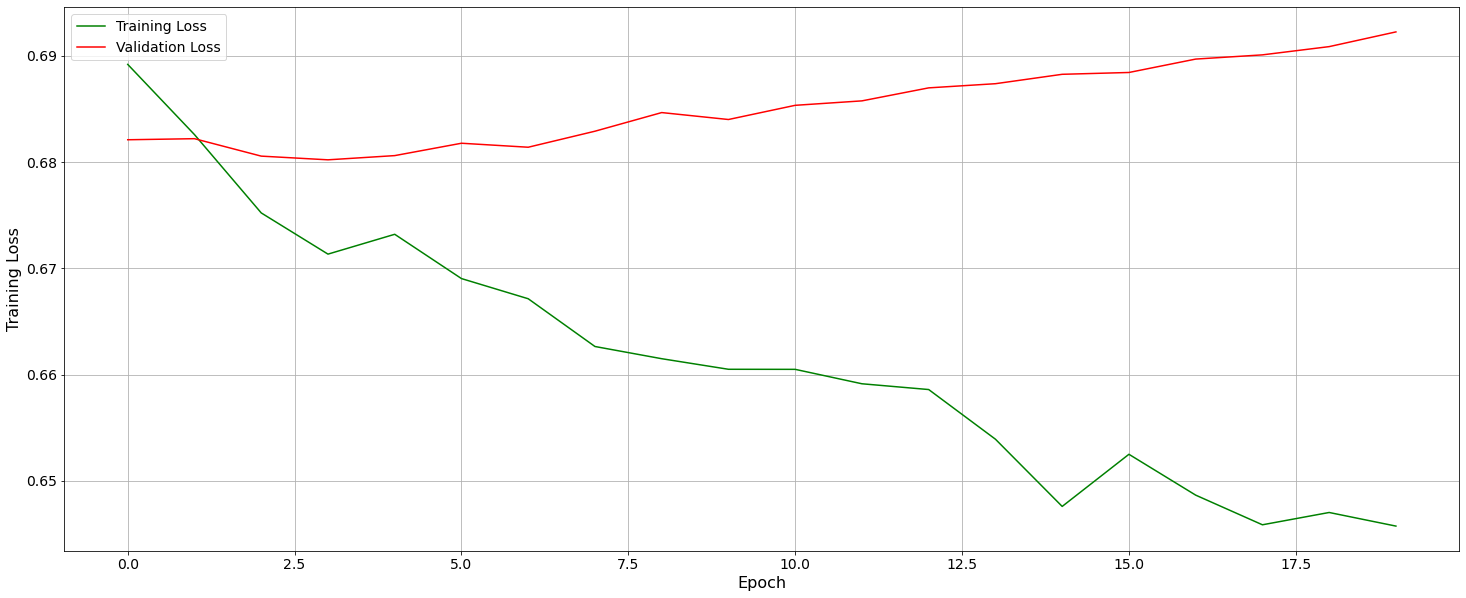

In [58]:
plot_epoch_loss(losses_train[0.0001])

In [59]:
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,0.0001,overall,class_scores,0.217270,0.406250,0.148289,0.496416,0.477534
1,0.0001,cluster1,class_scores,0.320513,0.609756,0.217391,0.620072,0.559915
2,0.0001,cluster2,class_scores,0.137931,0.254545,0.094595,0.372760,0.390809


In [60]:
print_res(metrics_train)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,0.0001,overall,class_scores,0.347287,0.682927,0.232848,0.618314,0.574623
1,0.0001,cluster1,class_scores,0.356021,0.703448,0.238318,0.632104,0.581768
2,0.0001,cluster2,class_scores,0.277778,0.526316,0.188679,0.480000,0.498595


#### With Attention Single Task Network

In [61]:
metrics_train,metrics_test, losses_train =  run_ssda_cp_st(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.0001],
                                                            epochs=20,
                                                            batch_size=4,
                                                            single_task=True,
                                                            with_attention=True)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)

Sample size from C1 in Train : (1003, 10)
1 : 428
0 : 575

Sample size from C2 in Train : (100, 10)
1 : 53
0 : 47

Train Size : (1103, 10)
1 : 481
0 : 622

Sample Size from C1 in Test : (279, 10)
1 : 115
0 : 164

Sample Size from C2 in Test : (279, 10)
1 : 148
0 : 131

Test Size : (558, 10)
1 : 263
0 : 295

Sample size from C1 in Val : (112, 10)
1 : 54
0 : 58

Sample size from C2 in Val : (112, 10)
1 : 44
0 : 68

Val Size : (224, 10)
1 : 98
0 : 126
Epoch : 0 | Batch : 100 | Total Loss : 0.7003666758537292 
True Rec Labels : tensor([[0.],
        [0.],
        [1.],
        [1.]], device='cuda:1')
Batch Class Predictions : tensor([0.4537, 0.4699, 0.4661, 0.4499], device='cuda:1',
       grad_fn=<SqueezeBackward0>)
[0. 0. 0. 0.]
Batch Accuracy class : 0.5
Epoch : 0 | Batch : 200 | Total Loss : 0.7207890152931213 
True Rec Labels : tensor([[1.],
        [1.],
        [1.],
        [0.]], device='cuda:1')
Batch Class Predict

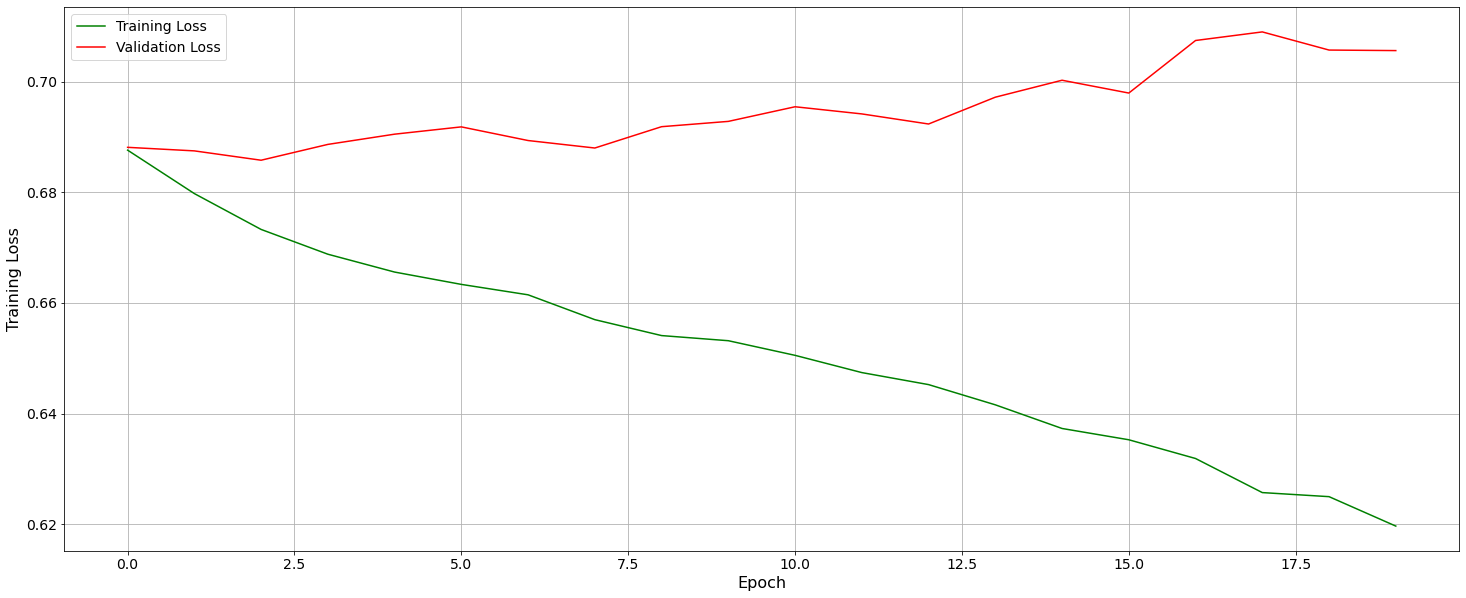

In [62]:
plot_epoch_loss(losses_train[0.0001])

In [63]:
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,0.0001,overall,class_scores,0.238482,0.415094,0.167300,0.496416,0.478565
1,0.0001,cluster1,class_scores,0.368421,0.756757,0.243478,0.655914,0.594300
2,0.0001,cluster2,class_scores,0.147465,0.231884,0.108108,0.336918,0.351764


In [64]:
print_res(metrics_train)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,0.0001,overall,class_scores,0.424886,0.786517,0.291060,0.656392,0.614984
1,0.0001,cluster1,class_scores,0.441379,0.842105,0.299065,0.676969,0.628663
2,0.0001,cluster2,class_scores,0.303797,0.461538,0.226415,0.450000,0.464271


### Adding Extra Linear Layer before Output Layer

#### Without Attention Single Task Network

In [67]:
metrics_train,metrics_test, losses_train =  run_ssda_cp_st(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.0001],
                                                            epochs=20,
                                                            batch_size=16,
                                                            single_task=True,
                                                            with_attention=False)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)

Sample size from C1 in Train : (1003, 10)
1 : 428
0 : 575

Sample size from C2 in Train : (100, 10)
1 : 53
0 : 47

Train Size : (1103, 10)
1 : 481
0 : 622

Sample Size from C1 in Test : (279, 10)
1 : 115
0 : 164

Sample Size from C2 in Test : (279, 10)
1 : 148
0 : 131

Test Size : (558, 10)
1 : 263
0 : 295

Sample size from C1 in Val : (112, 10)
1 : 54
0 : 58

Sample size from C2 in Val : (112, 10)
1 : 44
0 : 68

Val Size : (224, 10)
1 : 98
0 : 126
Avg Batch Loss Train : 0.6813274172769077
Avg Batch Loss Val : 0.6845281251839229
Avg Batch Loss Train : 0.6712186621583026
Avg Batch Loss Val : 0.6859039621693748
Avg Batch Loss Train : 0.6642415238463361
Avg Batch Loss Val : 0.6889466260160718
Avg Batch Loss Train : 0.6583246942879497
Avg Batch Loss Val : 0.6941535728318351
Avg Batch Loss Train : 0.6544555192408354
Avg Batch Loss Val : 0.693181791475841
Avg Batch Loss Train : 0.648184029088504
Avg Batch Loss Val : 0.69523751

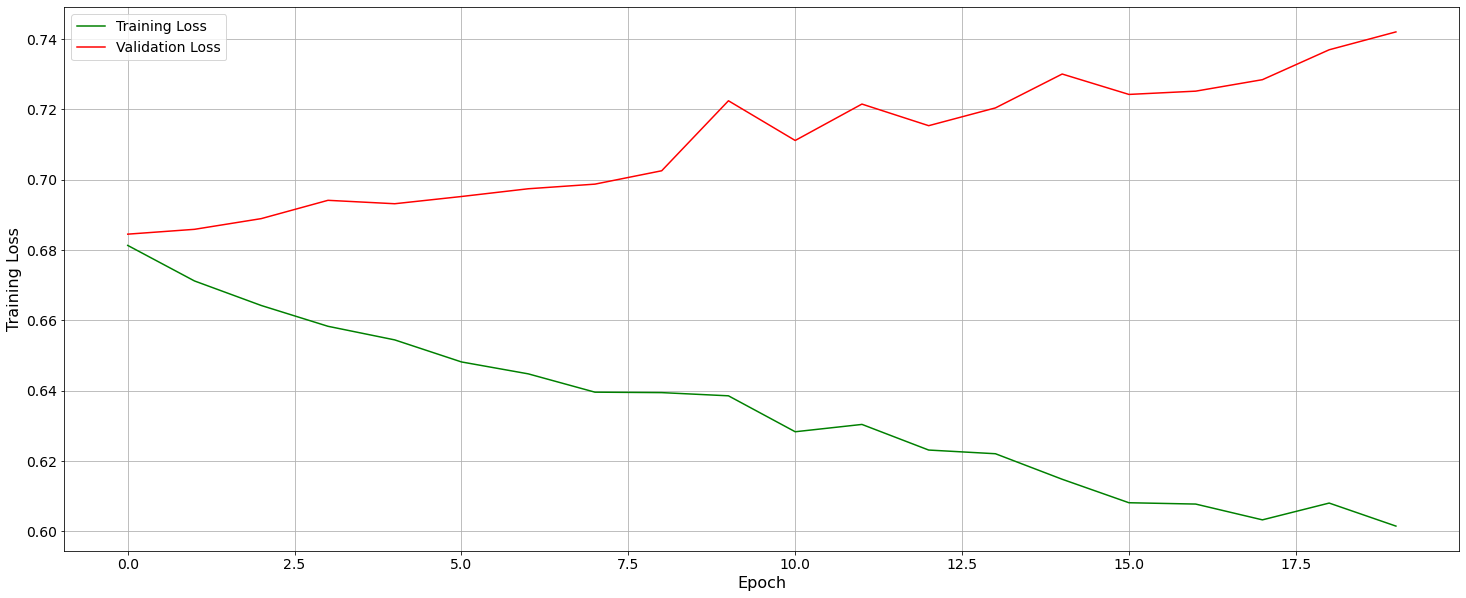

In [68]:
plot_epoch_loss(losses_train[0.0001])

In [69]:
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,0.0001,overall,class_scores,0.249307,0.459184,0.171103,0.514337,0.495721
1,0.0001,cluster1,class_scores,0.344371,0.722222,0.226087,0.645161,0.582556
2,0.0001,cluster2,class_scores,0.180952,0.306452,0.128378,0.383513,0.400067


In [70]:
print_res(metrics_train)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,0.0001,overall,class_scores,0.415663,0.754098,0.286902,0.648232,0.607278
1,0.0001,cluster1,class_scores,0.434635,0.795031,0.299065,0.667996,0.620837
2,0.0001,cluster2,class_scores,0.266667,0.454545,0.188679,0.450000,0.466680


#### With Attention Single Task Network

In [71]:
metrics_train,metrics_test, losses_train =  run_ssda_cp_st(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.0001],
                                                            epochs=20,
                                                            batch_size=4,
                                                            single_task=True,
                                                            with_attention=True)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)

Sample size from C1 in Train : (1003, 10)
1 : 428
0 : 575

Sample size from C2 in Train : (100, 10)
1 : 53
0 : 47

Train Size : (1103, 10)
1 : 481
0 : 622

Sample Size from C1 in Test : (279, 10)
1 : 115
0 : 164

Sample Size from C2 in Test : (279, 10)
1 : 148
0 : 131

Test Size : (558, 10)
1 : 263
0 : 295

Sample size from C1 in Val : (112, 10)
1 : 54
0 : 58

Sample size from C2 in Val : (112, 10)
1 : 44
0 : 68

Val Size : (224, 10)
1 : 98
0 : 126
Epoch : 0 | Batch : 100 | Total Loss : 0.6978853940963745 
True Rec Labels : tensor([[0.],
        [0.],
        [1.],
        [0.]], device='cuda:1')
Batch Class Predictions : tensor([0.4986, 0.4924, 0.4740, 0.4917], device='cuda:1',
       grad_fn=<SqueezeBackward0>)
[0. 0. 0. 0.]
Batch Accuracy class : 0.75
Epoch : 0 | Batch : 200 | Total Loss : 0.7065277695655823 
True Rec Labels : tensor([[0.],
        [1.],
        [1.],
        [0.]], device='cuda:1')
Batch Class Predic

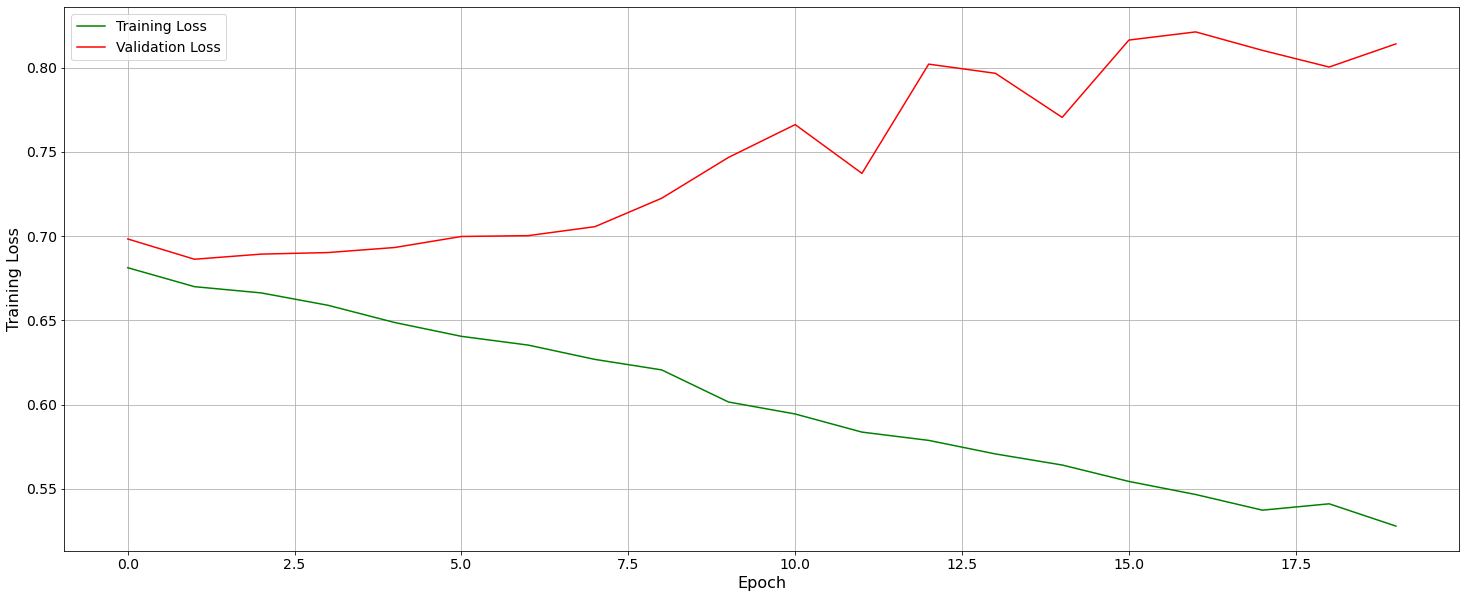

In [72]:
plot_epoch_loss(losses_train[0.0001])

In [73]:
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,0.0001,overall,class_scores,0.391892,0.480663,0.330798,0.516129,0.506077
1,0.0001,cluster1,class_scores,0.595745,0.767123,0.486957,0.727599,0.691649
2,0.0001,cluster2,class_scores,0.242187,0.287037,0.209459,0.304659,0.310837


In [74]:
print_res(metrics_train)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,0.0001,overall,class_scores,0.649189,0.812500,0.540541,0.745240,0.722039
1,0.0001,cluster1,class_scores,0.679887,0.863309,0.560748,0.774676,0.747330
2,0.0001,cluster2,class_scores,0.421053,0.476190,0.377358,0.450000,0.454637


## Loss Analysis - Multitask Network

### Using Batch Size of 1 and checking Word Loss

In [138]:
metrics_train,metrics_test, losses_train =  run_ssda_cp_mt(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.001],
                                                            word_pred_loss_weights=[0.1],
                                                            epochs=10,
                                                            batch_size=1,
                                                            single_task=False)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)
Exploded Train Shape : (7666, 4)
Exploded Test Shape : (6617, 4)

Sample size from C1 in Train : (5518, 5)
1 : 2417
0 : 3101

Sample size from C2 in Train : (551, 5)
1 : 272
0 : 279

Train Size : (6069, 5)
1 : 2689
0 : 3380

Sample Size from C1 in Test : (1534, 5)
1 : 656
0 : 878

Sample Size from C2 in Test : (1534, 5)
1 : 719
0 : 815

Test Size : (3068, 5)
1 : 1375
0 : 1693

Sample size from C1 in Val : (614, 5)
1 : 264
0 : 350

Sample size from C2 in Val : (614, 5)
1 : 295
0 : 319

Val Size : (1228, 5)
1 : 559
0 : 669
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Epoch : 0 | Batch : 100 | Total Loss : 0.5252690315246582 | Rec Loss : 0.5232288241386414 | Word Loss : 0.020401958376169205
T

In [139]:
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 0.1)",overall,class_scores,0.618951,0.448175,1.000000,0.448175,0.500000
1,"(0.001, 0.1)",overall,word_scores,0.444291,0.425447,0.464881,0.476532,0.475475
2,"(0.001, 0.1)",cluster1,class_scores,0.599087,0.427640,1.000000,0.427640,0.500000
3,"(0.001, 0.1)",cluster1,word_scores,0.457815,0.440160,0.476945,0.488918,0.487877
4,"(0.001, 0.1)",cluster2,class_scores,0.638260,0.468709,1.000000,0.468709,0.500000
5,"(0.001, 0.1)",cluster2,word_scores,0.430748,0.410832,0.452693,0.464146,0.463064


In [140]:
print_res(metrics_train)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 0.1)",overall,class_scores,0.614067,0.443071,1.000000,0.443071,0.500000
1,"(0.001, 0.1)",overall,word_scores,0.448223,0.429984,0.468077,0.470588,0.470400
2,"(0.001, 0.1)",cluster1,class_scores,0.609200,0.438021,1.000000,0.438021,0.500000
3,"(0.001, 0.1)",cluster1,word_scores,0.447739,0.429613,0.467460,0.473360,0.472890
4,"(0.001, 0.1)",cluster2,class_scores,0.660996,0.493648,1.000000,0.493648,0.500000
5,"(0.001, 0.1)",cluster2,word_scores,0.452763,0.433447,0.473881,0.442831,0.443654


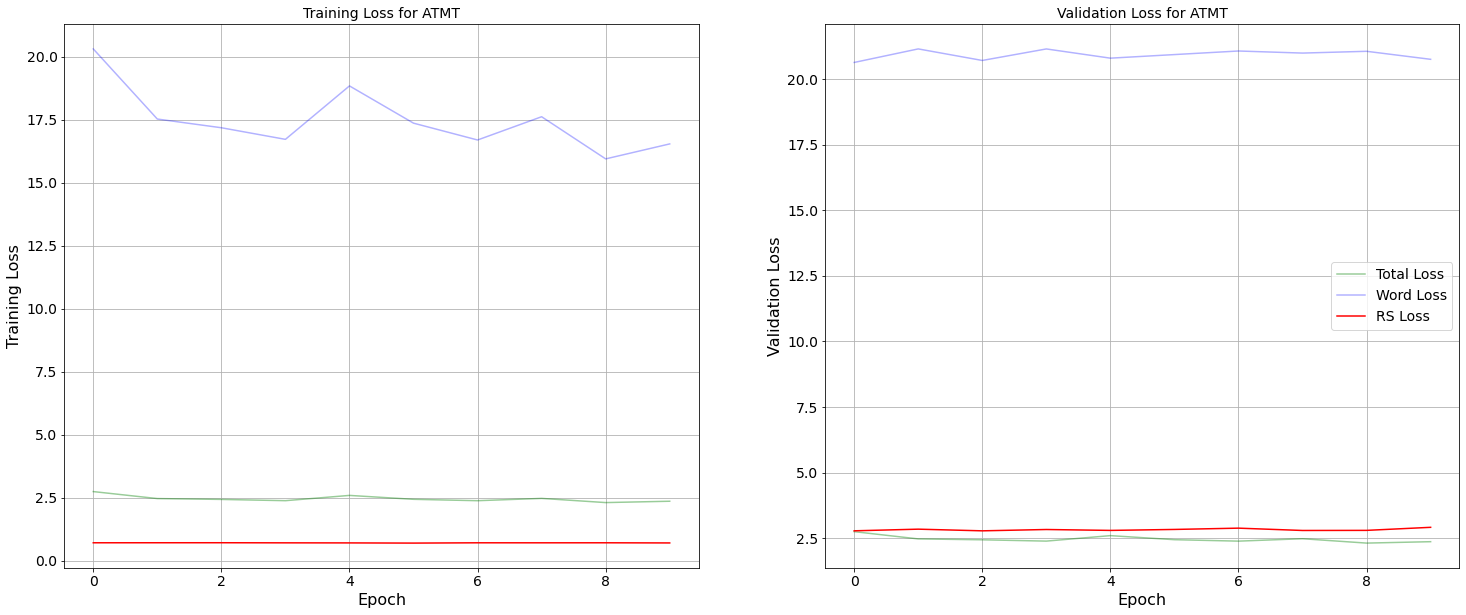

In [141]:
plot_epoch_loss_multi(losses_train[(0.001,0.1)])

### Using Larger Batch Size and Checking Word Loss

In [148]:
metrics_train,metrics_test, losses_train =  run_ssda_cp_mt(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.001],
                                                            word_pred_loss_weights=[0.1],
                                                            epochs=10,
                                                            batch_size=8,
                                                            single_task=False)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)
Exploded Train Shape : (7666, 4)
Exploded Test Shape : (6617, 4)

Sample size from C1 in Train : (5518, 5)
1 : 2417
0 : 3101

Sample size from C2 in Train : (551, 5)
1 : 272
0 : 279

Train Size : (6069, 5)
1 : 2689
0 : 3380

Sample Size from C1 in Test : (1534, 5)
1 : 656
0 : 878

Sample Size from C2 in Test : (1534, 5)
1 : 719
0 : 815

Test Size : (3068, 5)
1 : 1375
0 : 1693

Sample size from C1 in Val : (614, 5)
1 : 264
0 : 350

Sample size from C2 in Val : (614, 5)
1 : 295
0 : 319

Val Size : (1228, 5)
1 : 559
0 : 669
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Epoch : 0 | Batch : 100 | Total Loss : 0.9272388219833374 | Rec Loss : 0.7251465320587158 | Word Loss : 2.0209226608276367
Tru

In [149]:
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 0.1)",overall,class_scores,0.573279,0.455794,0.772364,0.484681,0.511699
1,"(0.001, 0.1)",overall,word_scores,0.499386,0.433600,0.588704,0.468709,0.479592
2,"(0.001, 0.1)",cluster1,class_scores,0.633826,0.494449,0.882622,0.563885,0.604181
3,"(0.001, 0.1)",cluster1,word_scores,0.499693,0.435294,0.586455,0.468709,0.478942
4,"(0.001, 0.1)",cluster2,class_scores,0.514377,0.416739,0.671766,0.405476,0.421159
5,"(0.001, 0.1)",cluster2,word_scores,0.499078,0.431915,0.590975,0.468709,0.480257


In [150]:
print_res(metrics_train)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 0.1)",overall,class_scores,0.645011,0.510745,0.875046,0.573241,0.604091
1,"(0.001, 0.1)",overall,word_scores,0.501828,0.436176,0.590746,0.461196,0.470929
2,"(0.001, 0.1)",cluster1,class_scores,0.653067,0.514401,0.894084,0.583907,0.618116
3,"(0.001, 0.1)",cluster1,word_scores,0.498061,0.433011,0.586111,0.460493,0.470507
4,"(0.001, 0.1)",cluster2,class_scores,0.566372,0.472906,0.705882,0.466425,0.469429
5,"(0.001, 0.1)",cluster2,word_scores,0.537125,0.465753,0.634328,0.468240,0.472641


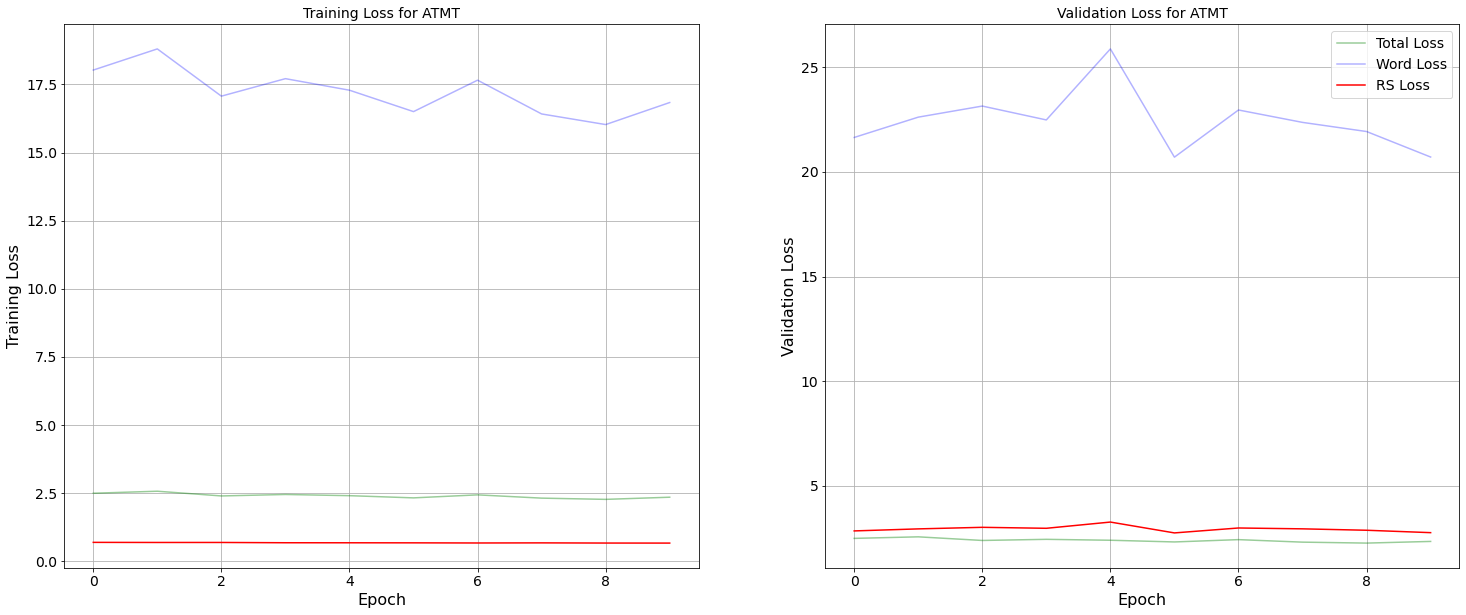

In [151]:
plot_epoch_loss_multi(losses_train[(0.001,0.1)])

## Using Tanh Activation when calculating Attention Weights

In [155]:
metrics_train,metrics_test, losses_train =  run_ssda_cp_mt(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.001],
                                                            word_pred_loss_weights=[2.0],
                                                            epochs=10,
                                                            batch_size=8,
                                                            single_task=False)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)
Exploded Train Shape : (7666, 4)
Exploded Test Shape : (6617, 4)

Sample size from C1 in Train : (5518, 5)
1 : 2417
0 : 3101

Sample size from C2 in Train : (551, 5)
1 : 272
0 : 279

Train Size : (6069, 5)
1 : 2689
0 : 3380

Sample Size from C1 in Test : (1534, 5)
1 : 656
0 : 878

Sample Size from C2 in Test : (1534, 5)
1 : 719
0 : 815

Test Size : (3068, 5)
1 : 1375
0 : 1693

Sample size from C1 in Val : (614, 5)
1 : 264
0 : 350

Sample size from C2 in Val : (614, 5)
1 : 295
0 : 319

Val Size : (1228, 5)
1 : 559
0 : 669
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Epoch : 0 | Batch : 100 | Total Loss : 79.69374084472656 | Rec Loss : 0.7012964487075806 | Word Loss : 39.49622344970703
True 

In [156]:
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 2.0)",overall,class_scores,0.523520,0.467429,0.594909,0.514668,0.522204
1,"(0.001, 2.0)",overall,word_scores,0.514353,0.434935,0.629254,0.465124,0.480009
2,"(0.001, 2.0)",cluster1,class_scores,0.627923,0.558859,0.716463,0.636897,0.646956
3,"(0.001, 2.0)",cluster1,word_scores,0.517994,0.438561,0.632565,0.467405,0.481759
4,"(0.001, 2.0)",cluster2,class_scores,0.427518,0.382838,0.484006,0.392438,0.397831
5,"(0.001, 2.0)",cluster2,word_scores,0.510689,0.431294,0.625910,0.462842,0.478244


In [157]:
print_res(metrics_train)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 2.0)",overall,class_scores,0.628003,0.566348,0.704723,0.630087,0.637717
1,"(0.001, 2.0)",overall,word_scores,0.517337,0.436867,0.634146,0.456418,0.469771
2,"(0.001, 2.0)",cluster1,class_scores,0.645232,0.580304,0.726520,0.650054,0.658488
3,"(0.001, 2.0)",cluster1,word_scores,0.515098,0.434250,0.632937,0.455781,0.469904
4,"(0.001, 2.0)",cluster2,class_scores,0.469595,0.434375,0.511029,0.430127,0.431142
5,"(0.001, 2.0)",cluster2,word_scores,0.538941,0.462567,0.645522,0.462795,0.467638


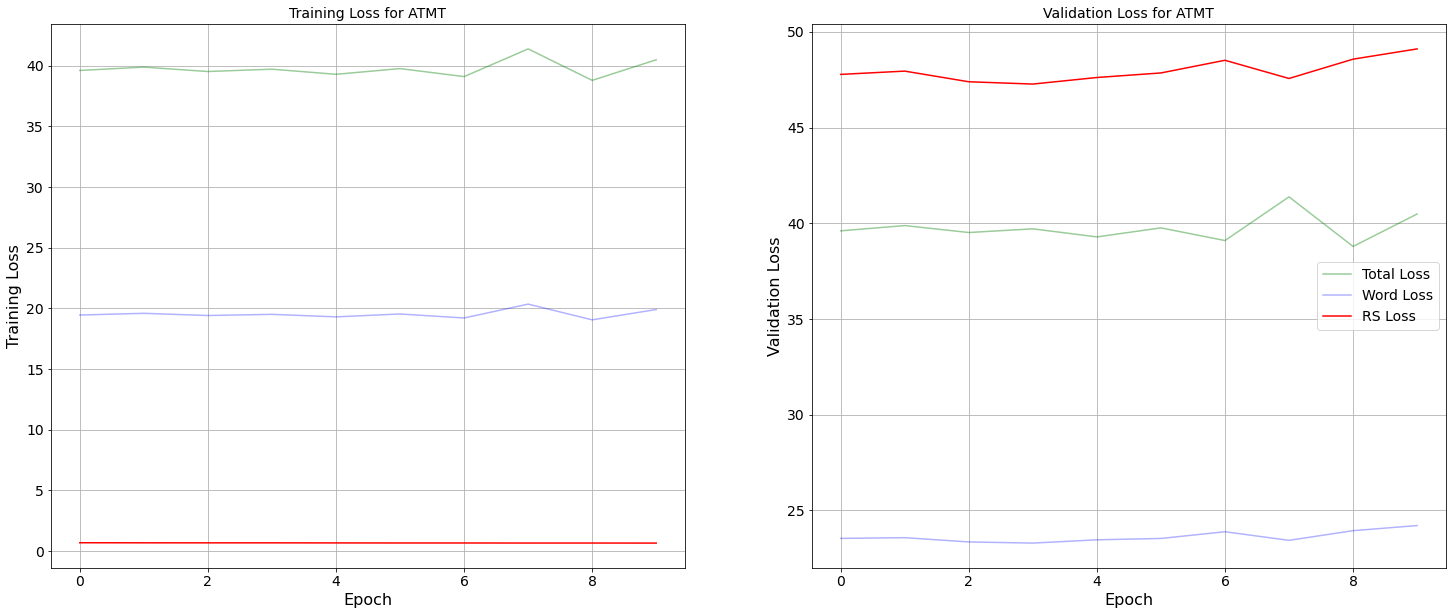

In [158]:
plot_epoch_loss_multi(losses_train[(0.001,2.0)])

## Adding a Linear Layer for the Context Word Network

In [163]:
metrics_train,metrics_test, losses_train =  run_ssda_cp_mt(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.001],
                                                            word_pred_loss_weights=[0.4],
                                                            epochs=10,
                                                            batch_size=16,
                                                            single_task=False)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)
Exploded Train Shape : (7666, 4)
Exploded Test Shape : (6617, 4)

Sample size from C1 in Train : (5518, 5)
1 : 2417
0 : 3101

Sample size from C2 in Train : (551, 5)
1 : 272
0 : 279

Train Size : (6069, 5)
1 : 2689
0 : 3380

Sample Size from C1 in Test : (1534, 5)
1 : 656
0 : 878

Sample Size from C2 in Test : (1534, 5)
1 : 719
0 : 815

Test Size : (3068, 5)
1 : 1375
0 : 1693

Sample size from C1 in Val : (614, 5)
1 : 264
0 : 350

Sample size from C2 in Val : (614, 5)
1 : 295
0 : 319

Val Size : (1228, 5)
1 : 559
0 : 669
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Epoch : 0 | Batch : 100 | Total Loss : 0.9412420988082886 | Rec Loss : 0.6499232649803162 | Word Loss : 0.7282971143722534
Tru

In [164]:
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 0.4)",overall,class_scores,0.567347,0.532907,0.606545,0.585398,0.587384
1,"(0.001, 0.4)",overall,word_scores,0.387737,0.513740,0.311369,0.557366,0.535056
2,"(0.001, 0.4)",cluster1,class_scores,0.749819,0.715076,0.788110,0.775098,0.776743
3,"(0.001, 0.4)",cluster1,word_scores,0.349386,0.506849,0.266571,0.550847,0.526142
4,"(0.001, 0.4)",cluster2,class_scores,0.406150,0.376485,0.440890,0.395698,0.398359
5,"(0.001, 0.4)",cluster2,word_scores,0.422778,0.519068,0.356623,0.563885,0.544309


In [165]:
print_res(metrics_train)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 0.4)",overall,class_scores,0.742755,0.715615,0.772034,0.763058,0.763976
1,"(0.001, 0.4)",overall,word_scores,0.458673,0.653616,0.353300,0.616906,0.597101
2,"(0.001, 0.4)",cluster1,class_scores,0.778044,0.751639,0.806372,0.798478,0.799348
3,"(0.001, 0.4)",cluster1,word_scores,0.448105,0.656705,0.340079,0.617434,0.595323
4,"(0.001, 0.4)",cluster2,class_scores,0.437931,0.412338,0.466912,0.408348,0.409083
5,"(0.001, 0.4)",cluster2,word_scores,0.544681,0.633663,0.477612,0.611615,0.608064


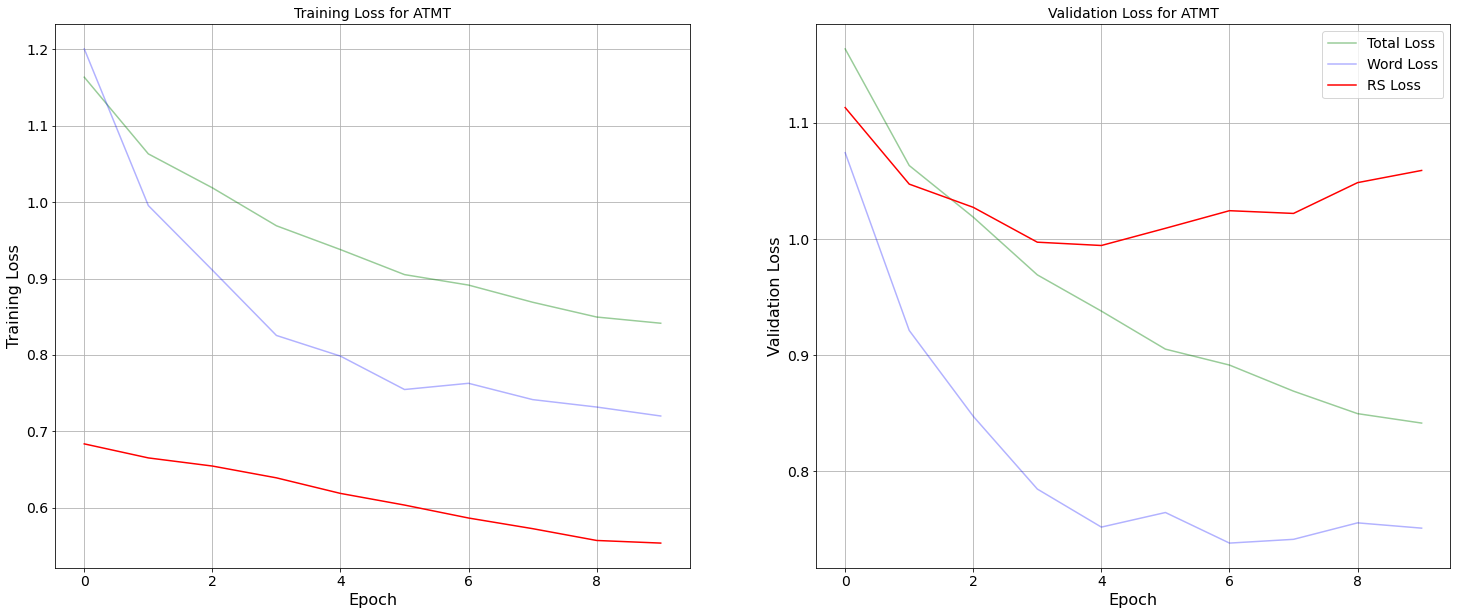

In [166]:
plot_epoch_loss_multi(losses_train[(0.001,0.4)])

## Using an Extra Attention Layer + Linear Layer for the Context Word Network

In [170]:
metrics_train,metrics_test, losses_train =  run_ssda_cp_mt(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.001],
                                                            word_pred_loss_weights=[0.4],
                                                            epochs=10,
                                                            batch_size=16,
                                                            single_task=False)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)
Exploded Train Shape : (7666, 4)
Exploded Test Shape : (6617, 4)

Sample size from C1 in Train : (5518, 5)
1 : 2417
0 : 3101

Sample size from C2 in Train : (551, 5)
1 : 272
0 : 279

Train Size : (6069, 5)
1 : 2689
0 : 3380

Sample Size from C1 in Test : (1534, 5)
1 : 656
0 : 878

Sample Size from C2 in Test : (1534, 5)
1 : 719
0 : 815

Test Size : (3068, 5)
1 : 1375
0 : 1693

Sample size from C1 in Val : (614, 5)
1 : 264
0 : 350

Sample size from C2 in Val : (614, 5)
1 : 295
0 : 319

Val Size : (1228, 5)
1 : 559
0 : 669
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Epoch : 0 | Batch : 100 | Total Loss : 1.0175533294677734 | Rec Loss : 0.6791344881057739 | Word Loss : 0.846047043800354
True

In [171]:
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 0.4)",overall,class_scores,0.669382,0.681750,0.657455,0.708931,0.704096
1,"(0.001, 0.4)",overall,word_scores,0.662079,0.662319,0.661839,0.695893,0.692805
2,"(0.001, 0.4)",cluster1,class_scores,0.825077,0.838050,0.812500,0.852673,0.847594
3,"(0.001, 0.4)",cluster1,word_scores,0.810207,0.907143,0.731988,0.844850,0.835042
4,"(0.001, 0.4)",cluster2,class_scores,0.526615,0.537681,0.515994,0.565189,0.562292
5,"(0.001, 0.4)",cluster2,word_scores,0.538819,0.495122,0.590975,0.546936,0.551096


In [172]:
print_res(metrics_train)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 0.4)",overall,class_scores,1.000000,1.000000,1.000000,1.000000,1.000000
1,"(0.001, 0.4)",overall,word_scores,0.988134,0.990627,0.985653,0.989125,0.988864
2,"(0.001, 0.4)",cluster1,class_scores,1.000000,1.000000,1.000000,1.000000,1.000000
3,"(0.001, 0.4)",cluster1,word_scores,0.987065,0.990020,0.984127,0.988220,0.987894
4,"(0.001, 0.4)",cluster2,class_scores,1.000000,1.000000,1.000000,1.000000,1.000000
5,"(0.001, 0.4)",cluster2,word_scores,0.998138,0.996283,1.000000,0.998185,0.998233


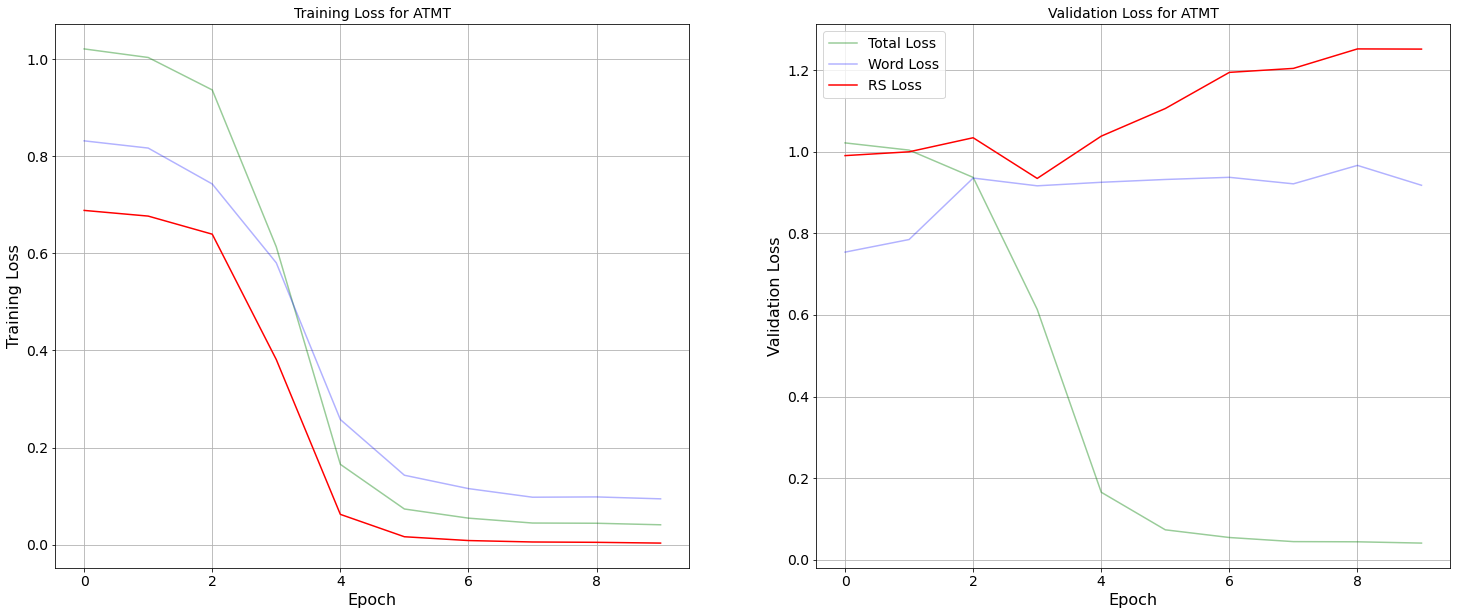

In [173]:
plot_epoch_loss_multi(losses_train[(0.001,0.4)])

In [176]:
metrics_train,metrics_test, losses_train,model_dict =  run_ssda_cp_mt(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.001],
                                                            word_pred_loss_weights=[0.4],
                                                            epochs=5,
                                                            batch_size=16,
                                                            single_task=False)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)
Exploded Train Shape : (7666, 4)
Exploded Test Shape : (6617, 4)

Sample size from C1 in Train : (5518, 5)
1 : 2417
0 : 3101

Sample size from C2 in Train : (551, 5)
1 : 272
0 : 279

Train Size : (6069, 5)
1 : 2689
0 : 3380

Sample Size from C1 in Test : (1534, 5)
1 : 656
0 : 878

Sample Size from C2 in Test : (1534, 5)
1 : 719
0 : 815

Test Size : (3068, 5)
1 : 1375
0 : 1693

Sample size from C1 in Val : (614, 5)
1 : 264
0 : 350

Sample size from C2 in Val : (614, 5)
1 : 295
0 : 319

Val Size : (1228, 5)
1 : 559
0 : 669
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Epoch : 0 | Batch : 100 | Total Loss : 0.9615588188171387 | Rec Loss : 0.684438943862915 | Word Loss : 0.6927996277809143
True

In [177]:
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 0.4)",overall,class_scores,0.643872,0.682410,0.609455,0.697849,0.689547
1,"(0.001, 0.4)",overall,word_scores,0.666667,0.647984,0.686459,0.691004,0.690592
2,"(0.001, 0.4)",cluster1,class_scores,0.818677,0.836248,0.801829,0.848110,0.842259
3,"(0.001, 0.4)",cluster1,word_scores,0.804365,0.876061,0.743516,0.836375,0.828306
4,"(0.001, 0.4)",cluster2,class_scores,0.473445,0.520868,0.433936,0.547588,0.540894
5,"(0.001, 0.4)",cluster2,word_scores,0.553491,0.494279,0.628821,0.545632,0.553490


In [178]:
print_res(metrics_train)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 0.4)",overall,class_scores,0.999814,0.999628,1.000000,0.999835,0.999852
1,"(0.001, 0.4)",overall,word_scores,0.978319,0.977444,0.979197,0.980063,0.979998
2,"(0.001, 0.4)",cluster1,class_scores,1.000000,1.000000,1.000000,1.000000,1.000000
3,"(0.001, 0.4)",cluster1,word_scores,0.978377,0.978183,0.978571,0.980246,0.980113
4,"(0.001, 0.4)",cluster2,class_scores,0.998165,0.996337,1.000000,0.998185,0.998208
5,"(0.001, 0.4)",cluster2,word_scores,0.977778,0.970588,0.985075,0.978221,0.978403


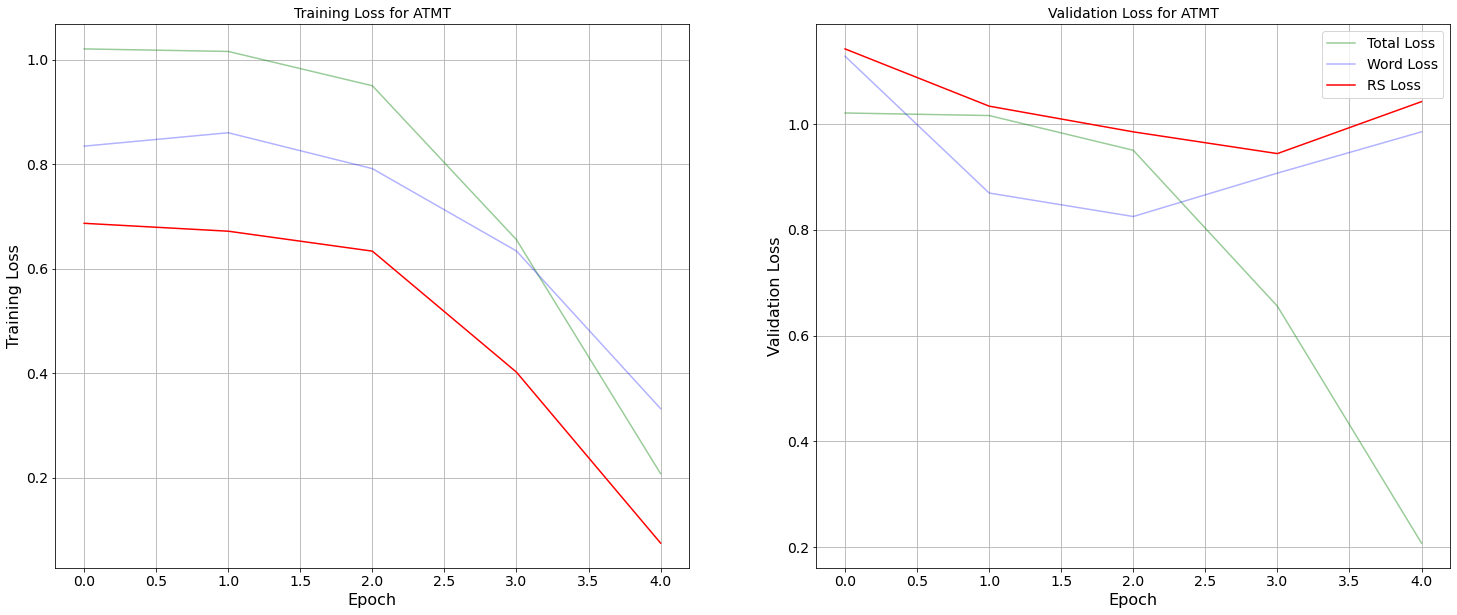

In [179]:
plot_epoch_loss_multi(losses_train[(0.001,0.4)])

## Checking Attention Weights

### Docs in Cluster 1

In [180]:
doc_ids = doc_2_cluster_map[14]

In [181]:
print(doc_ids[:5])

[0, 9, 64, 94, 242]


In [183]:
display(data.iloc[doc_ids[:5]])

,title,text,source_partisan_score,binary_ps,processed_text,processed_title,context_word_pos,context_word_neg,drop_
0,Top general warns that 'divisiveness leads to ...,(medianame) America's most senior general warn...,-1.0,0,medianame america most senior general warned ...,top general warns that divisiveness leads to d...,"[defeat, grow, leads]","[incredible, ambiguity, clauses]",False
9,Pompeo recalls Afghan peace envoy after Trump ...,Secretary of State Mike Pompeo said Sunday tha...,1.0,1,secretary state mike pompeo said sunday that t...,pompeo recalls afghan peace envoy after trump ...,"[afghan, envoy, recalls]","[modify, measuring, sitcom]",False
64,White House: Trump's 'second thoughts' on Chin...,President Trump told reporters Sunday that he ...,1.0,1,president trump told reporters sunday that has...,white house trumps second thoughts on china tr...,"[thoughts, greatly, DROP_THIS]","[appearing, epic, honeymoon]",False
94,'None of this is normal': AOC joins other Demo...,Reps. Alexandria Ocasio-Cortez and Ayanna Pres...,-2.0,0,reps alexandria ocasio cortez and ayanna press...,none of this is normal aoc joins other democra...,"[none, boycott, normal]","[spin, loaded, shortened]",False
242,Comey Told Obama that Flynn’s Conversations wi...,Former FBI director James Comey told President...,2.0,1,former fbi director james comey told president...,comey told obama that flynn conversations with...,"[according, conversations, leg]","[regents, flex, rest]",False


In [184]:
display(HTML(data.iloc[doc_ids[:5]].to_html()))

This cluster seems like it talks about US - Foreign Relations

### Docs in cluster 2

In [185]:
doc_ids_2 = doc_2_cluster_map[44]

In [192]:
print(doc_ids_2[-5:])

[94803, 94879, 94899, 94969, 94981]


In [190]:
display(data.iloc[doc_ids_2[-5:]])

,title,text,source_partisan_score,binary_ps,processed_text,processed_title,context_word_pos,context_word_neg,drop_
94803,Exclusive--Trump Super PAC Releases 'Witch Hun...,The America First Action PAC released a timeli...,2.0,1,the america first action pac released timeline...,exclusivetrump super pac releases witch hunt t...,"[timeline, witch, hunt]","[smashed, scouts, bern]",False
94879,"SHAPIRO: Weirdly, Nancy Pelosi Only Invokes Ca...",On Thursday’s episode of “The reportername Sho...,2.0,1,thursday episode the reportername show the me...,shapiro weirdly nancy pelosi only invokes cath...,"[convenient, weird, shapiro]","[hung, annoying, truman]",False
94899,6 highlights from Ukraine envoy Bill Taylor's ...,President Donald Trump has insisted there was ...,-1.0,0,president donald trump has insisted there was ...,highlights from ukraine envoy bill taylors ex...,"[highlights, envoy, taylor]","[compass, bounce, resigned]",False
94969,Rose McGowan Calls on Joe Biden to Drop Out as...,Joe Biden has most of corporate Hollywood and ...,2.0,1,joe biden has most corporate hollywood and gro...,rose mcgowan calls on joe biden to drop out as...,"[rose, roi, drop]","[enabled, undertaking, filmmakers]",False
94981,Justin Amash becomes the first Republican in C...,Michigan Republican Rep. Justin Amash thinks P...,-2.0,0,michigan republican rep justin amash thinks pr...,justin amash becomes the first republican in c...,"[becomes, conduct, ama]","[connor, hammering, expression]",False


In [191]:
display(HTML(data.iloc[doc_ids_2[-5:]].to_html()))

 Cluster seems about joe biden

## Attention Weight Check

In [196]:
tokenizer = load_tokenizer()

In [193]:
test_article = data["processed_text"].iloc[94981]

In [197]:
test_word = "conduct"

In [194]:
test_article

'michigan republican rep justin amash thinks president donald trump conduct office impeachable that attorney general william barr knowingly misled the public about the conclusions special counsel robert mueller report and that his republican colleagues congress are turning blind eye all contrary barr portrayal mueller report reveals that president trump engaged specific actions and pattern behavior that meet the threshold for impeachment amash tweeted lengthy thread saturday becoming the first and only congressional republican argue that the fbi investigation into trump campaign and its alleged connection russian officials established grounds for impeachment while several prominent democrats have also called for impeachment house speaker nancy pelosi has repeatedly sidestepped the issue instead calling for more investigations amash sits nexus the republican party libertarian who known for breaking from the party line and has partnered with democrats the past but also the house freedom 

In [216]:
sample_df = data.iloc[94981].to_frame().T
sample_df["context_word"] = "conduct"
sample_df["class_label"] = 1
sample_df["word_label"] = 1
sample_df["which_cluster"] = 2

In [217]:
sample_df

,title,text,source_partisan_score,binary_ps,processed_text,processed_title,context_word_pos,context_word_neg,drop_,context_word,class_label,word_label,which_cluster
94981,Justin Amash becomes the first Republican in C...,Michigan Republican Rep. Justin Amash thinks P...,-2,0,michigan republican rep justin amash thinks pr...,justin amash becomes the first republican in c...,"[becomes, conduct, ama]","[connor, hammering, expression]",False,conduct,1,1,2


In [218]:
single_sample_dataset = CPDatasetMT(sample_df)
single_dataloader = DataLoader(single_sample_dataset,batch_size=1,num_workers=1, shuffle=True)

Index(['title', 'text', 'source_partisan_score', 'binary_ps', 'processed_text',
       'processed_title', 'context_word_pos', 'context_word_neg', 'drop_',
       'context_word', 'class_label', 'word_label', 'which_cluster'],
      dtype='object')


In [226]:
attention_weights = None
model = model_dict[(0.001,0.4)]
model.eval()
for batch, (x1,x2,y1,y2,wc) in enumerate(single_dataloader):
    x1,x2 = x1.to(torch.device('cuda:1')),x2.to(torch.device('cuda:1'))
    y_pred, context_pred, attention_cvector,attention_weights = model(x1, x2)

In [224]:
attention_cvector.size()

torch.Size([1, 768])

In [227]:
attention_weights.size()

torch.Size([1, 500])

In [238]:
tokens = tokenizer.decode(x1.squeeze().numpy().tolist())

In [241]:
tokens = tokens.split(" ")

In [242]:
len(tokens)

435

In [245]:
tokens = tokens + ["[PAD]"]*65

In [246]:
len(tokens)

500

In [248]:
token_weight_tuples = []
for token,att_w in zip(tokens,attention_weights.squeeze().cpu().detach().numpy().tolist()):
    token_weight_tuples.append((token,att_w))

In [250]:
print("Top 10 highest Attention Weights")
print(sorted(token_weight_tuples,key=lambda x: x[1],reverse=True)[:10])

Top 10 highest Attention Weights
[('william', 0.05006416141986847), ('that', 0.048424068838357925), ('far', 0.04227188974618912), ('unwavering', 0.04022790491580963), ('conclusions', 0.038410067558288574), ('mueller', 0.03578826040029526), ('while', 0.033043909817934036), ('republicans', 0.032495271414518356), ('caucus,', 0.031124096363782883), ('with', 0.029742147773504257)]


In [252]:
print("Top 10 Lowest Attention Weights")
print(sorted(token_weight_tuples,key=lambda x: x[1],reverse=False)[:10])

Top 10 Lowest Attention Weights
[('s', -0.054843030869960785), ('made', -0.05226673558354378), ('’', -0.04446795582771301), ('actions', -0.04262540489435196), ('conclusions', -0.04256197065114975), ('from', -0.04111357405781746), ('trump', -0.040636610239744186), ('congress', -0.03712286800146103), ('he', -0.03625140339136124), ('may', -0.036070920526981354)]
